# Import

In [8]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import torch.nn as nn
from torch.functional import F
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import make_grid
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
import numpy as np
from tqdm.notebook import tqdm
from minisom import MiniSom

# Data load

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mihalko711/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


In [10]:
img_path = os.path.join(path, "EuroSAT")

# Dataet

In [11]:
class EuroSATDataset(Dataset):
    def __init__(self, csv_path, image_root, filt_class=None, return_label=False):
        self.df = pl.read_csv(csv_path).drop(pl.read_csv(csv_path).columns[0])
        self.image_root = Path(image_root)
        self.return_label = return_label

        self.transform = T.Compose([
            T.Resize((64, 64)),  # Гарантируем размер 64x64
            T.ToTensor(),        # Переводит [0, 255] -> [0.0, 1.0]
            T.Normalize(
                mean=[0.5, 0.5, 0.5], # (x - 0.5) / 0.5
                std=[0.5, 0.5, 0.5]   # Результат: [-1.0, 1.0]
            )
        ])

        if filt_class is not None:
            self.df = self.df.filter(pl.col("Label")==filt_class)
            
    def __len__(self):
        return self.df.height

    def __getitem__(self, idx):
        row = self.df.row(idx, named=True)

        img_path = self.image_root / row["Filename"]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        if self.return_label:
            return image, row["Label"], row["ClassName"]

        return image

torch.Size([3, 64, 64])


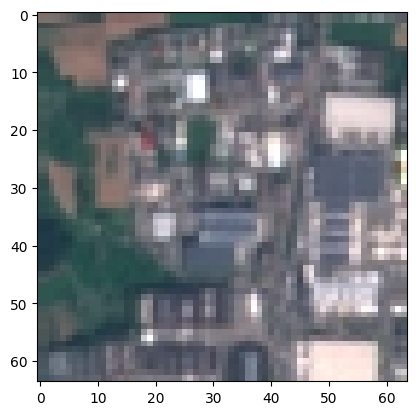

In [12]:
dataset = EuroSATDataset(
    csv_path=os.path.join(img_path, "train.csv"),
    image_root=os.path.join(img_path),
    return_label=True
)

idx = np.random.randint(len(dataset))

x, label, name = dataset[idx]
print(x.shape)
plt.imshow(x.permute(1, 2, 0) * 0.5 + 0.5)

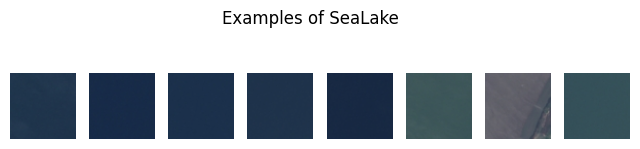

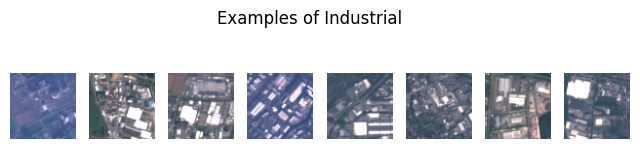

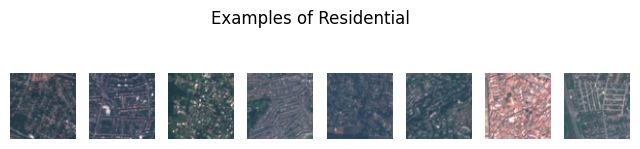

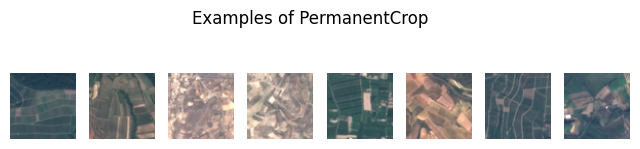

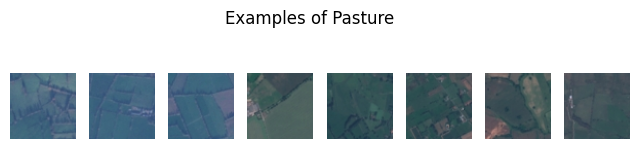

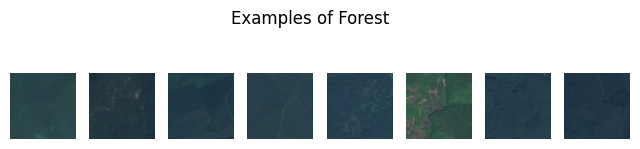

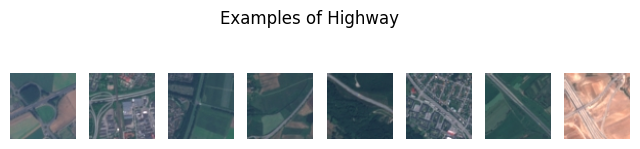

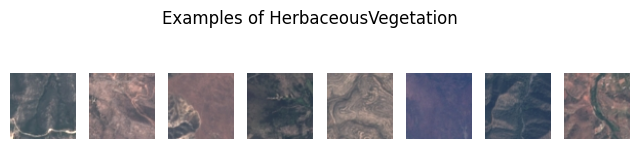

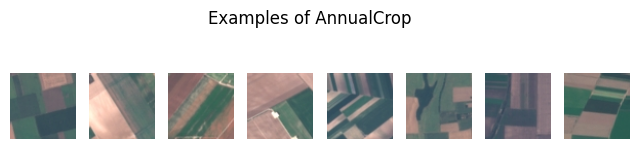

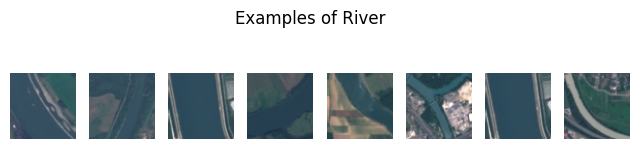

In [13]:
class_name = "AnnualCrop"
n = 8

def plot_n_rand_class(dataset, class_name, n):
    idxs = dataset.df \
        .with_columns(
            pl.arange(0, pl.len()).alias("idx")
        ) \
        .filter(
            pl.col("ClassName") == class_name
        ) \
        .select("idx").to_numpy().ravel()
    
    n_rand_idxs = np.random.choice(idxs, size=n)
    
    fig = plt.figure(figsize=(n, 2))
    fig.suptitle(f"Examples of {class_name}")
    for i, idx in enumerate(n_rand_idxs):
        x, label, class_name = dataset[idx]
        ax = fig.add_subplot(1, n, i + 1)
        ax.imshow(x.permute(1, 2, 0) * 0.5 + 0.5)
        ax.axis("off")


for class_name in dataset.df["ClassName"].unique():
    plot_n_rand_class(dataset, class_name, n)

# Model class

In [17]:
class TopoResNet(nn.Module):
    def __init__(self, num_classes=10, embedding_dim=64, pretrained=True):
        super().__init__()
        

        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        self.backbone = models.resnet18(weights=weights)
        
        
        num_features = self.backbone.fc.in_features
        
        # замена родной головы на пустышку
        self.backbone.fc = nn.Identity()
        

        # создание своего промежуточного слоя нужного размера
        self.projection = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )
        
        # финальный слой для классификации
        self.classifier = nn.Linear(embedding_dim, num_classes)
    
    def forward(self, x, return_embedding=False):
        # прогон через resnet (без старой головы)
        features = self.backbone(x)
        
        embedding = self.projection(features)
        
        # для получения просто эмбеддинга
        if return_embedding:
            return embedding
        
        logits = self.classifier(embedding)
        return logits, embedding

    def save_weights(self, path: str):
        """
        Сохраняет веса модели в файл.
        """
        os.makedirs(os.path.dirname(path), exist_ok=True)

        torch.save(
            {
                "model_state_dict": self.state_dict(),
                "num_classes": self.classifier.out_features,
                "embedding_dim": self.projection[-1].out_features,
            },
            path
        )

    def load_weights(self, path: str, map_location="cpu"):
        """
        Загружает веса модели из файла.
        """
        checkpoint = torch.load(path, map_location=map_location)
        self.load_state_dict(checkpoint["model_state_dict"])



def base_train_loop(model, criterion, optimizer, train_loader, test_loader, epochs):
    epoch_loop = tqdm(range(epochs), desc="Итерации по эпохам", leave=False)
    history = {
        "train_loss": [],
        "test_loss": [],
        'train_acc': [],
        "test_acc": []
    }
    for epoch in epoch_loop:
        model.train()
        train_total_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc="Итерация по батчам(трейн)", leave=False):
            if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
                labels = batch[1].to(device)
            else:
                raise ValueError("Для Fine-tuning нужны метки классов!")
    
            optimizer.zero_grad()
            
            logits, _ = model(imgs)
            
            loss = criterion(logits, labels)
            
            loss.backward()
            optimizer.step()
            
            train_total_loss += loss.item()
            
            # Точность (Accuracy)
            _, predicted = torch.max(logits.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        model.eval()
        test_total_loss = 0
        test_correct = 0
        test_total = 0
        for batch in tqdm(test_loader, desc="Итерация по батчам(тест)", leave=False):
            if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
                labels = batch[1].to(device)
            else:
                raise ValueError("Для Fine-tuning нужны метки классов!")
    
            with torch.no_grad():
                logits, _ = model(imgs)
                loss = criterion(logits, labels)
            
            test_total_loss += loss.item()
            

            _, predicted = torch.max(logits.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
        
        
            
        epoch_loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        epoch_loop.set_postfix(
            train_loss=train_total_loss/len(train_loader),
            train_acc=train_correct/train_total,
            test_loss=test_total_loss/len(test_loader),
            test_acc=test_correct/test_total
        )

        history['train_loss'].append(train_total_loss/len(train_loader))
        history['train_acc'].append(train_correct/train_total)
        history['test_loss'].append(test_total_loss/len(test_loader))
        history['test_acc'].append(test_correct/test_total)

    return model, history

In [18]:
train_ds = EuroSATDataset(
    csv_path=os.path.join(img_path, "train.csv"),
    image_root=os.path.join(img_path),
    return_label=True
)

val_ds = EuroSATDataset(
    csv_path=os.path.join(img_path, "validation.csv"),
    image_root=os.path.join(img_path),
    return_label=True
)

test_ds = EuroSATDataset(
    csv_path=os.path.join(img_path, "test.csv"),
    image_root=os.path.join(img_path),
    return_label=True
)

In [19]:
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

In [40]:
# Настройки
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TopoResNet(num_classes=10, embedding_dim=64).to(device)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

model, history = base_train_loop(model, criterion, optimizer, train_loader, val_loader, epochs)
# модель уже обучена и в памяти
model.save_weights("../checkpoints/toporesnet.pth")

Итерации по эпохам:   0%|          | 0/10 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

Итерация по батчам(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Итерация по батчам(тест):   0%|          | 0/22 [00:00<?, ?it/s]

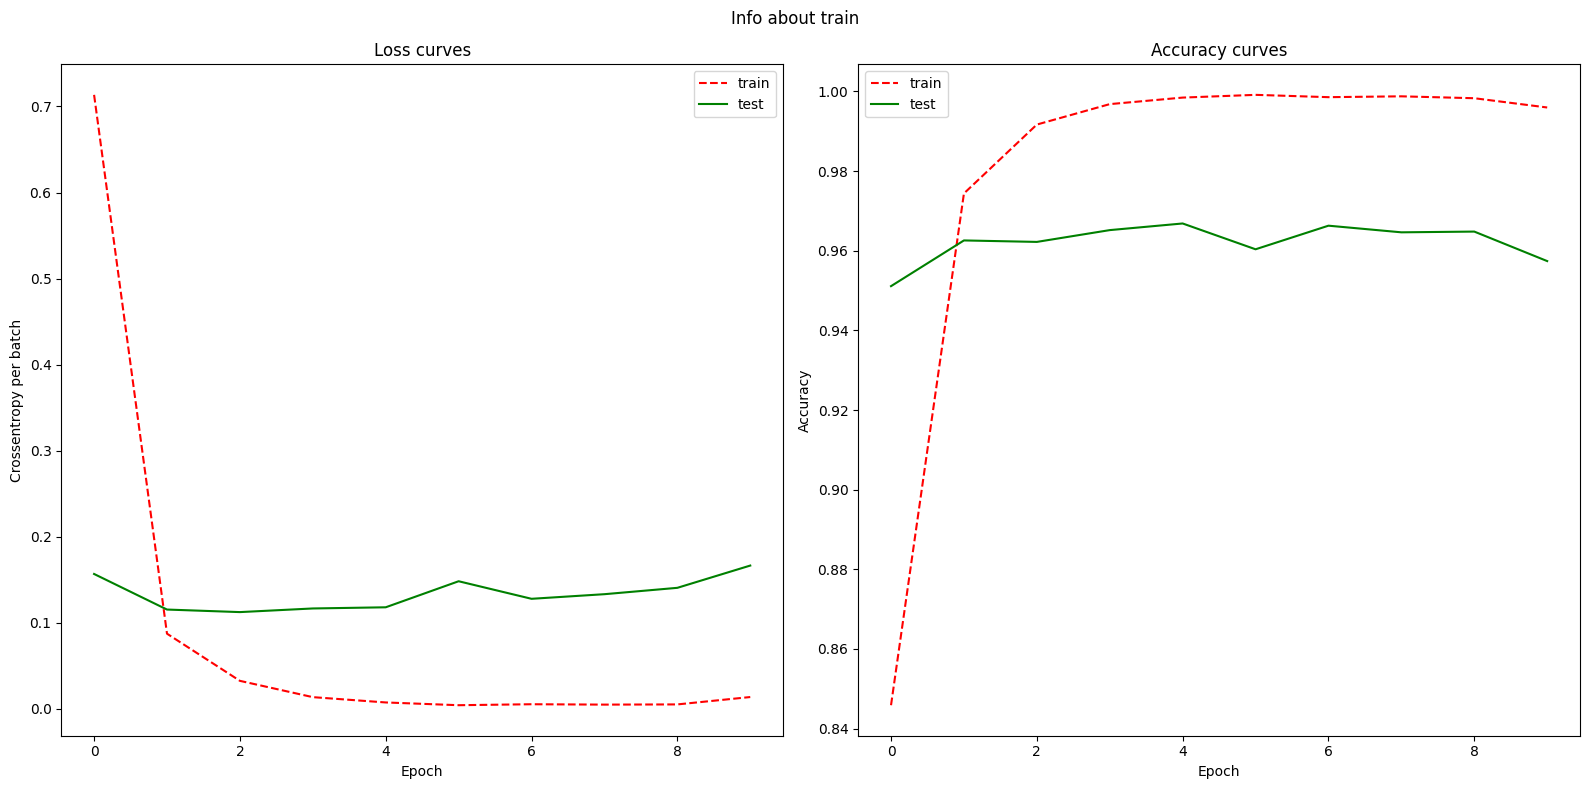

In [47]:
fig = plt.figure(figsize=(16, 8))

ax_loss = fig.add_subplot(1, 2, 1)
ax_loss.plot(history['train_loss'], c='red', ls='--', label='train')
ax_loss.plot(history['test_loss'], c='green', label='test')
ax_loss.set(title='Loss curves', xlabel='Epoch', ylabel='Crossentropy per batch')
ax_loss.legend()

ax_accuracy = fig.add_subplot(1, 2, 2)
ax_accuracy.plot(history['train_acc'], c='red', ls='--', label='train')
ax_accuracy.plot(history['test_acc'], c='green', label='test')
ax_accuracy.set(title='Accuracy curves', xlabel='Epoch', ylabel='Accuracy')
ax_accuracy.legend()

fig.suptitle('Info about train')
fig.tight_layout()

# Загрузка модели

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TopoResNet(num_classes=10, embedding_dim=64)
model.load_weights("../checkpoints/toporesnet.pth")
model.to(device)
model.eval()

/tmp/ipykernel_21269/3081180298.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=map_location)


TopoResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# MiniSom

## Генерация эмбеддингов на трейне и тесте

In [21]:
with torch.no_grad():
    embedding_lst = []
    label_lst = []
    for batch in tqdm(train_loader, desc='Генерация эмбеддингов(трейн)'):
        if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
                labels = batch[1].to(device)
        else:
            raise ValueError("Для Fine-tuning нужны метки классов!")
        embeddings = model(imgs, return_embedding=True).cpu().numpy()
        embedding_lst.append(embeddings)
        label_lst.append(labels.cpu().numpy())

    embeddings_train = np.concatenate(embedding_lst, axis=0)
    labels_train = np.concatenate(label_lst, axis=0)

    embedding_lst = []
    label_lst = []
    for batch in tqdm(test_loader, desc='Генерация эмбеддингов(тест)'):
        if isinstance(batch, (list, tuple)):
                imgs = batch[0].to(device)
                labels = batch[1].to(device)
        else:
            raise ValueError("Для Fine-tuning нужны метки классов!")
        embeddings = model(imgs, return_embedding=True).cpu().numpy()
        embedding_lst.append(embeddings)
        label_lst.append(labels.cpu().numpy())

    embeddings_test = np.concatenate(embedding_lst, axis=0)
    labels_test = np.concatenate(label_lst, axis=0)

Генерация эмбеддингов(трейн):   0%|          | 0/74 [00:00<?, ?it/s]

Генерация эмбеддингов(тест):   0%|          | 0/11 [00:00<?, ?it/s]

## Тренировка кучи SOMов разного размера

In [ ]:
with open(Path(img_path) / 'label_map.json', 'r') as fp:
    labels_dict = json.load(fp)

inv_labels_dict = {label: cls_name for cls_name, label in labels_dict.items()}

som_configs = {
    1: {"x": 2, "y": 2, "input_len": embeddings_train.shape[1], "sigma": 1., "learning_rate": 0.5},
    2: {"x": 3, "y": 3, "input_len": embeddings_train.shape[1], "sigma": 1., "learning_rate": 0.5},
    3: {"x": 4, "y": 4, "input_len": embeddings_train.shape[1], "sigma": 1., "learning_rate": 0.5},
    4: {"x": 8, "y": 8, "input_len": embeddings_train.shape[1], "sigma": 1., "learning_rate": 0.5},
    5: {"x": 16, "y": 16, "input_len": embeddings_train.shape[1], "sigma": 1., "learning_rate": 0.5},
    6: {"x": 32, "y": 32, "input_len": embeddings_train.shape[1], "sigma": 1., "learning_rate": 0.5},
    7: {"x": 64, "y": 64, "input_len": embeddings_train.shape[1], "sigma": 1., "learning_rate": 0.5},
}

iterations = 10_000
som_trained = {}

for cfg_name, cfg in tqdm(som_configs.items(), desc="Тренировка моделей"):
    
    som = MiniSom(**cfg)
    som.random_weights_init(embeddings_train)
    som.train(embeddings_train, iterations)
    som_trained[cfg_name] = som

## Функция для генерации карт с лейблами

Проходимся по всем эмбеддингам, находим победителя в картах Кохенена, после чего добавляем метку класса в словарь победителя.
После всего прохода считаем для каждого победителя самий частий класс и его отображаем

Во втором случае для каждому элементу карты модель сопоставляет класс, по этому классу  и ведем раскраску

In [27]:
def plot_som_legend_full(som, embeddings, labels, class_names=None, save_path=None):
    """
    Визуализирует SOM:
    - цифры классов в ячейках
    - легенда с форматом "цифра - имя класса", цвет совпадает с текстом
    """
    plt.figure(figsize=(8, 8))
    wmap = {}

    # собираем метки по нейронам
    for x, t in zip(embeddings, labels):
        w = som.winner(x)
        if w in wmap:
            wmap[w].append(t)
        else:
            wmap[w] = [t]

    # рисуем текст для нейронов
    for (x, y), class_list in wmap.items():
        most_common = Counter(class_list).most_common(1)[0][0]
        color = plt.cm.rainbow(most_common / max(labels))
        plt.text(x + 0.5, y + 0.5, str(most_common),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 11},
                 ha='center', va='center')

    plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
    plt.title("SOM: наиболее частые классы")
    plt.xticks([])
    plt.yticks([])

    # легенда
    if class_names is not None:
        # если исходный словарь вида {"cat":0}, инвертируем
        if all(isinstance(k, str) for k in class_names.keys()):
            inv_class_names = {v: k for k, v in class_names.items()}
        else:
            inv_class_names = class_names

        legend_elements = [
            Patch(facecolor=plt.cm.rainbow(k / max(labels)),
                  label=f"{k} - {inv_class_names[k]}")
            for k in sorted(inv_class_names)
        ]
        plt.legend(handles=legend_elements, loc=[1.0, 0.25], fontsize=10)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


def plot_som_comparison(som, embeddings_train, labels_train, embeddings_test, labels_test, class_names=None, save_path=None):
    """
    Визуализирует SOM:
    - цифры классов в ячейках
    - легенда с форматом "цифра - имя класса", цвет совпадает с текстом
    Сравнивает на трейне и тесте
    """
    fig = plt.figure(figsize=(16, 8))
    ax_train = fig.add_subplot(1, 2, 1)
    wmap = {}

    # собираем метки по нейронам
    for x, t in zip(embeddings_train, labels_train):
        w = som.winner(x)
        if w in wmap:
            wmap[w].append(t)
        else:
            wmap[w] = [t]

    # рисуем текст для нейронов
    for (x, y), class_list in wmap.items():
        most_common = Counter(class_list).most_common(1)[0][0]
        color = plt.cm.rainbow(most_common / max(labels_train))
        ax_train.text(x + 0.5, y + 0.5, str(most_common),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 11},
                 ha='center', va='center')

    ax_train.set_xlim(0, som.get_weights().shape[0])
    ax_train.set_ylim(0, som.get_weights().shape[1])
    ax_train.set_title("SOM: наиболее частые классы трейна")
    ax_train.set_xticks([])
    ax_train.set_yticks([])

    ax_test = fig.add_subplot(1, 2, 2)
    wmap = {}

    # собираем метки по нейронам
    for x, t in zip(embeddings_test, labels_test):
        w = som.winner(x)
        if w in wmap:
            wmap[w].append(t)
        else:
            wmap[w] = [t]

    # рисуем текст для нейронов
    for (x, y), class_list in wmap.items():
        most_common = Counter(class_list).most_common(1)[0][0]
        color = plt.cm.rainbow(most_common / max(labels_test))
        ax_test.text(x + 0.5, y + 0.5, str(most_common),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 11},
                 ha='center', va='center')

    ax_test.set_xlim(0, som.get_weights().shape[0])
    ax_test.set_ylim(0, som.get_weights().shape[1])
    ax_test.set_title("SOM: наиболее частые классы теста")
    ax_test.set_xticks([])
    ax_test.set_yticks([])

    # легенда
    if class_names is not None:
        if all(isinstance(k, str) for k in class_names.keys()):
            inv_class_names = {v: k for k, v in class_names.items()}
        else:
            inv_class_names = class_names

        legend_elements = [
            Patch(facecolor=plt.cm.rainbow(k / max(labels_train)),
                  label=f"{k} - {inv_class_names[k]}")
            for k in sorted(inv_class_names)
        ]
        ax_test.legend(handles=legend_elements, loc=[1.0, 0.25], fontsize=10)
    fig.suptitle("Сравнение частотнх карт классов на трейне и тесте")
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
    plt.show()

### Генерация трейна

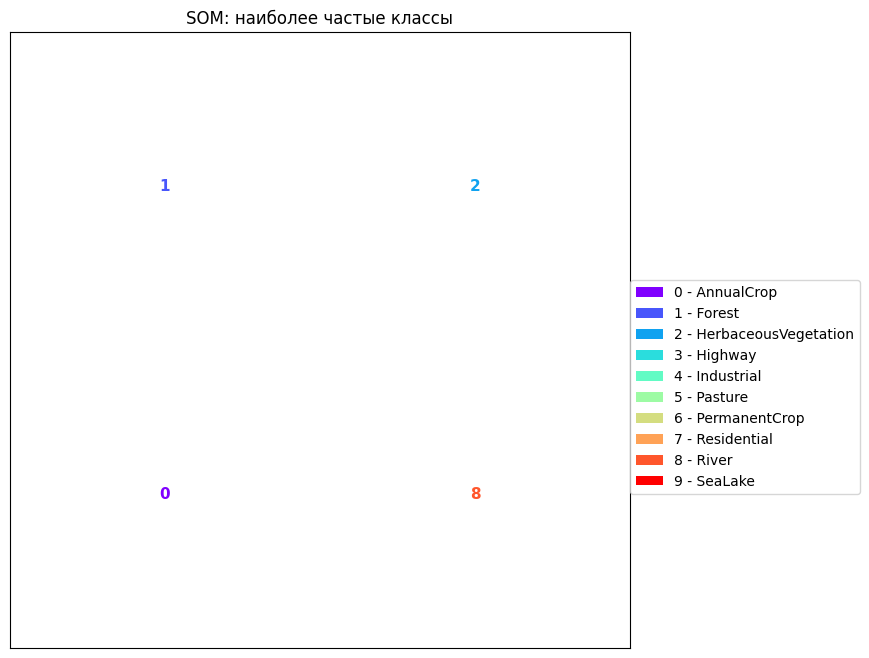

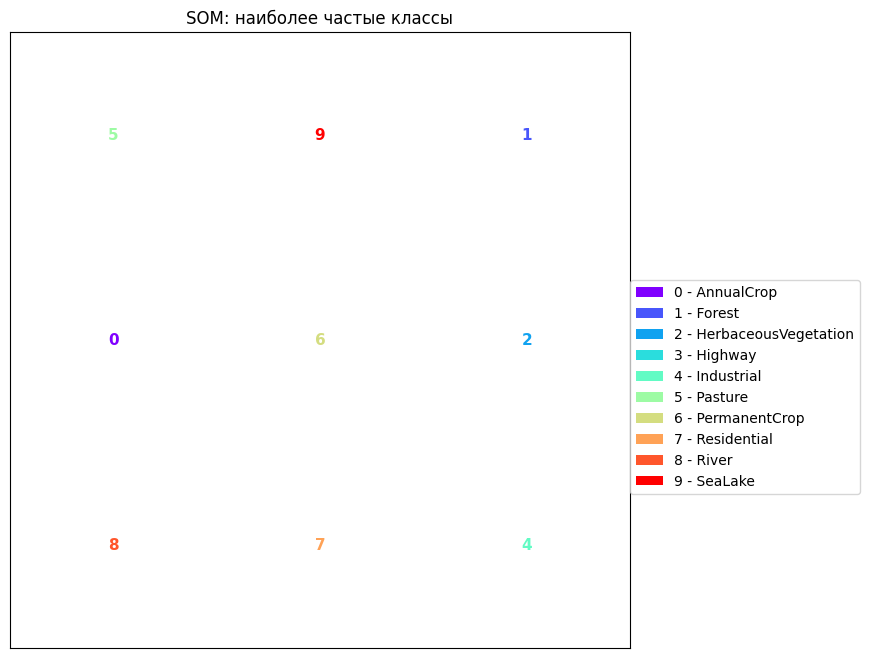

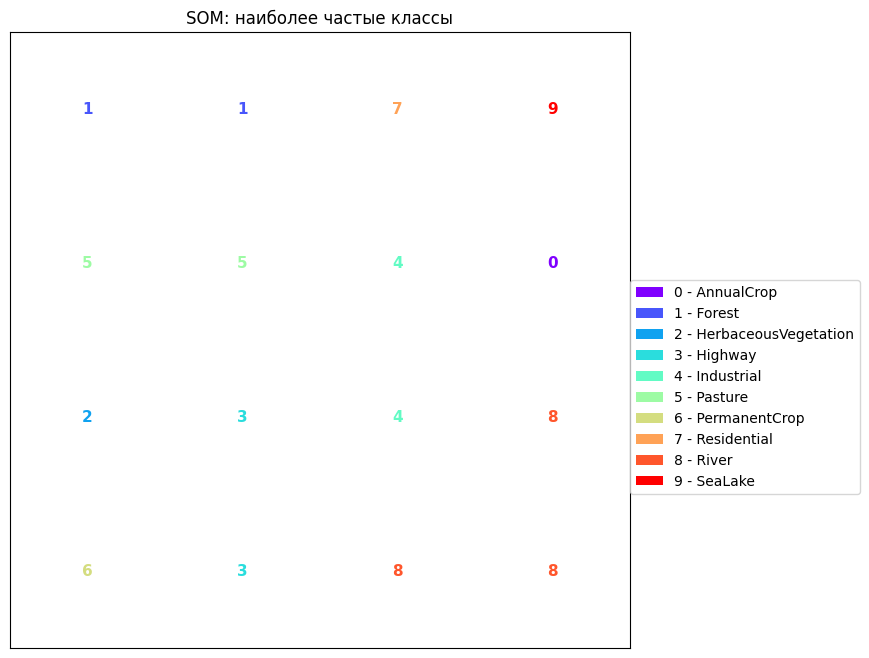

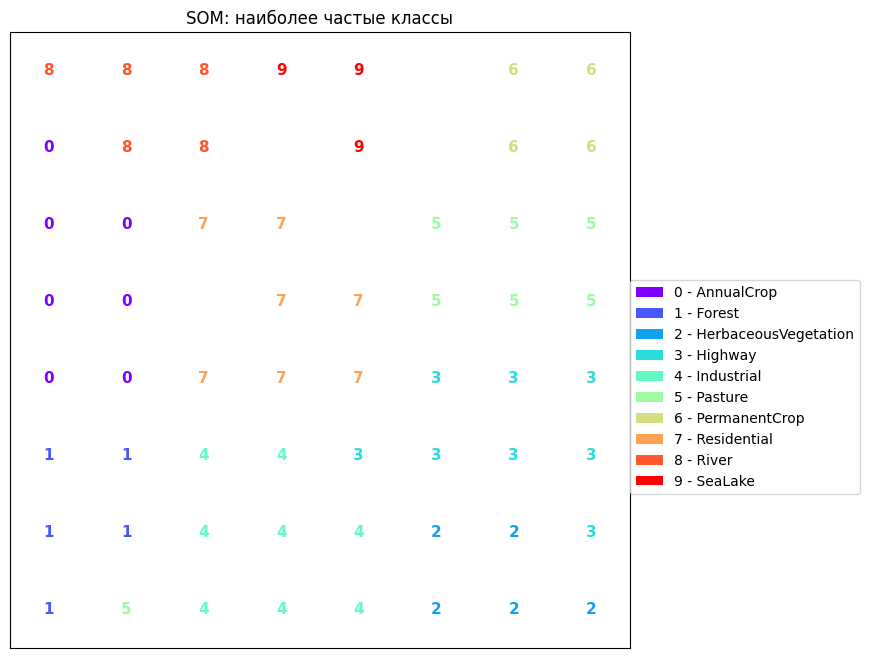

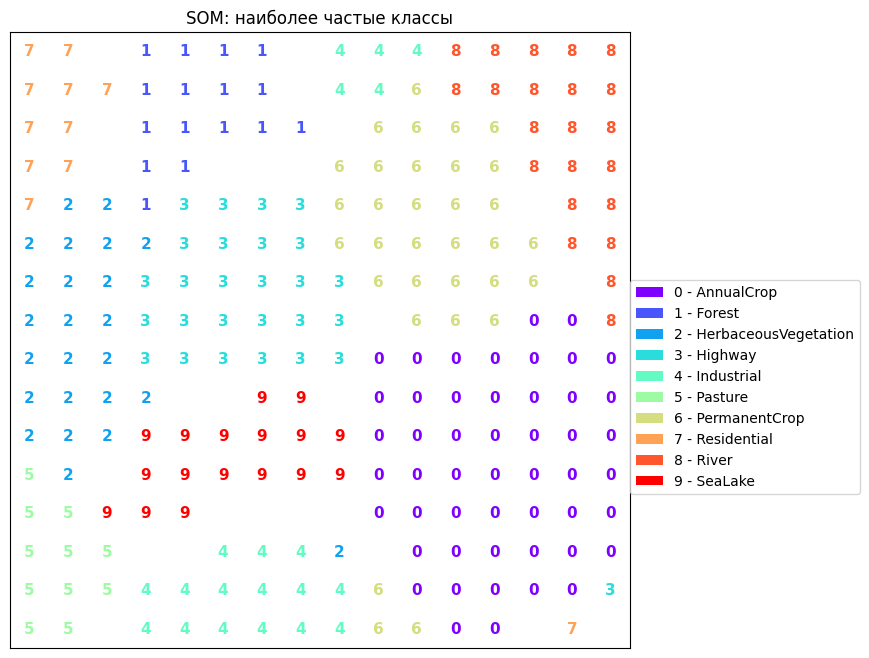

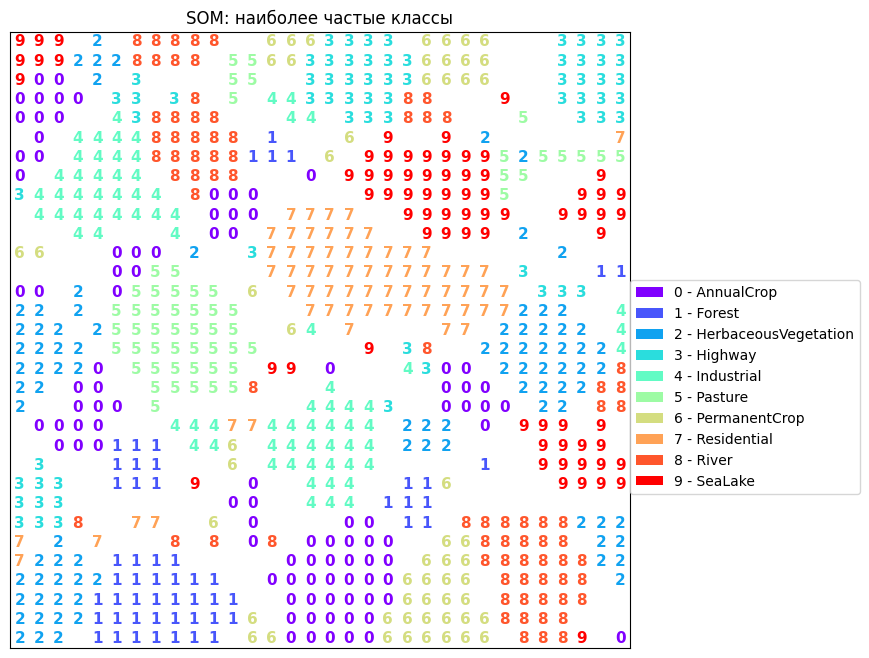

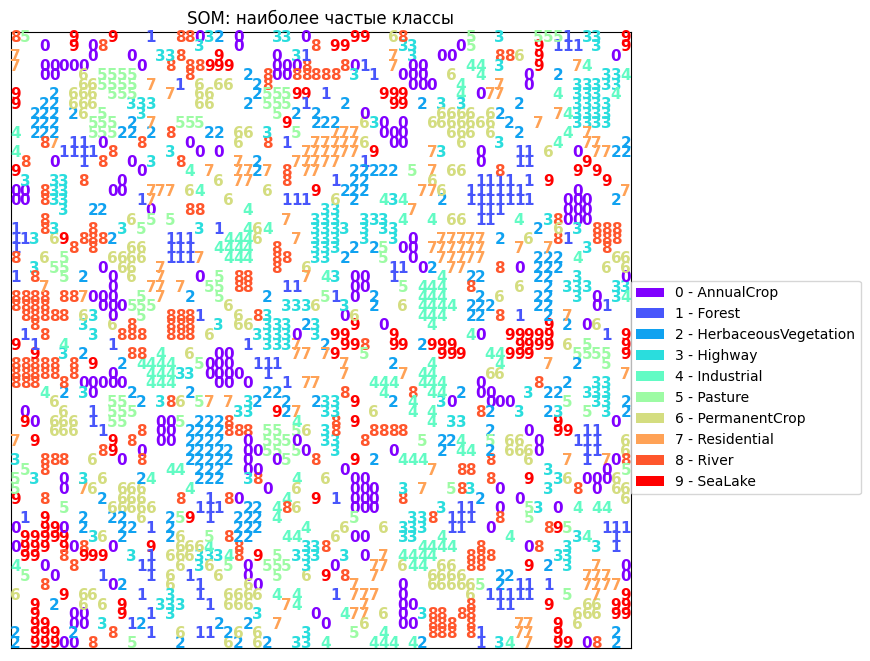

In [29]:
for cfg_name, som in som_trained.items():
    plot_som_legend_full(
        som=som,
        embeddings=embeddings_train,
        labels=labels_train,
        class_names=labels_dict,
        save_path=f"../resulting_images/som_{som.get_weights().shape[0]}x{som.get_weights().shape[1]}_most_freq_clses_on_train.png"
    )

### Генерация теста

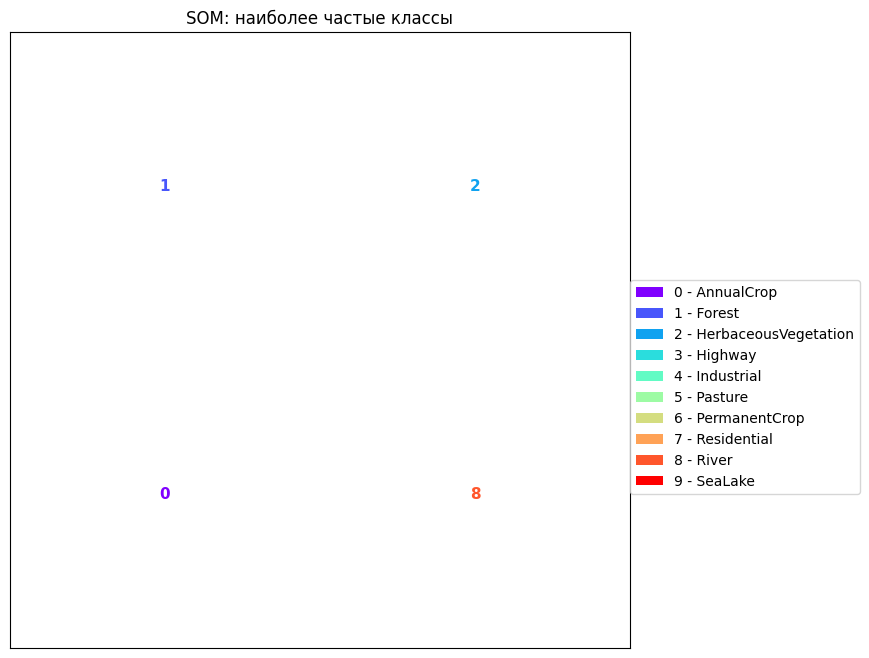

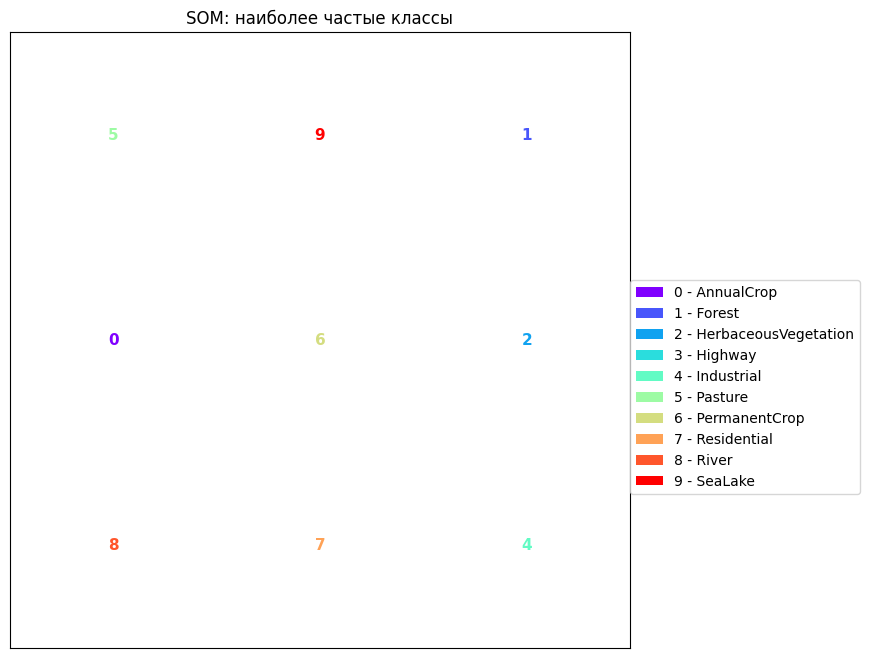

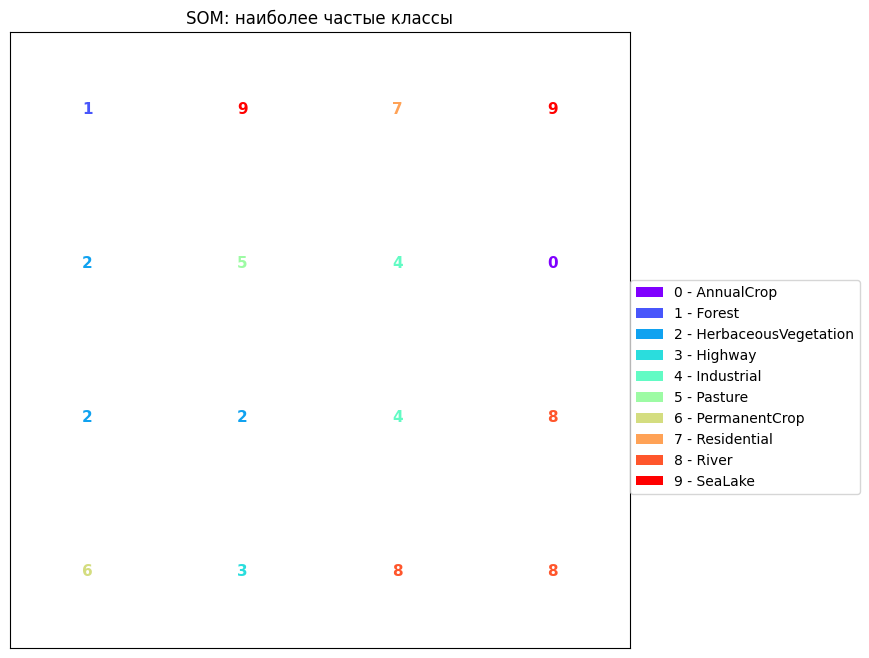

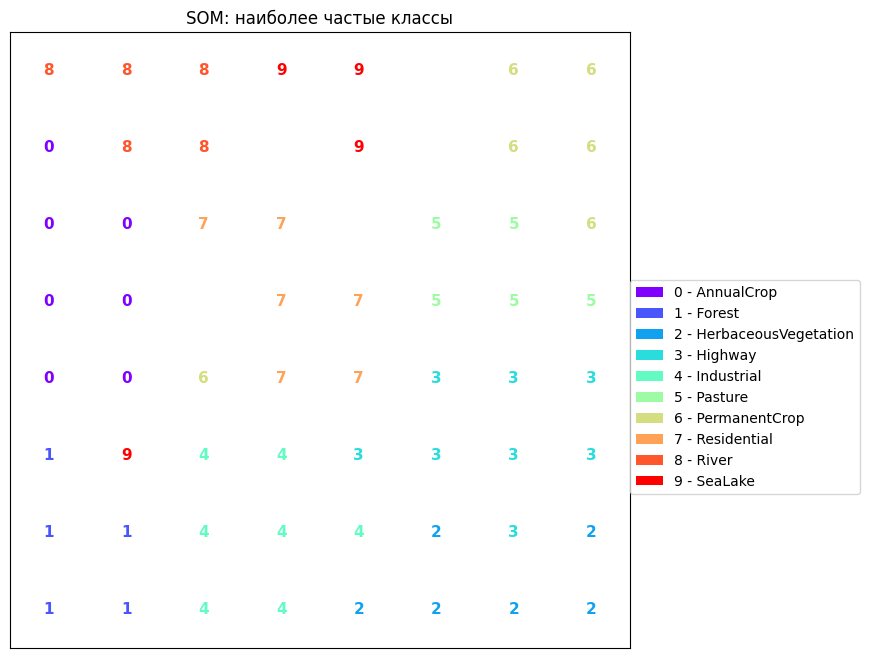

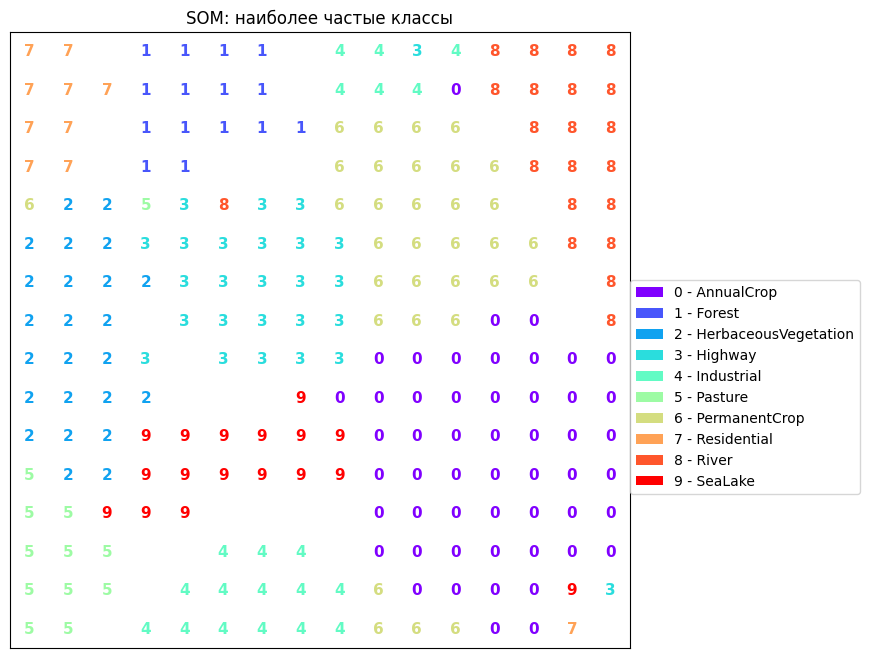

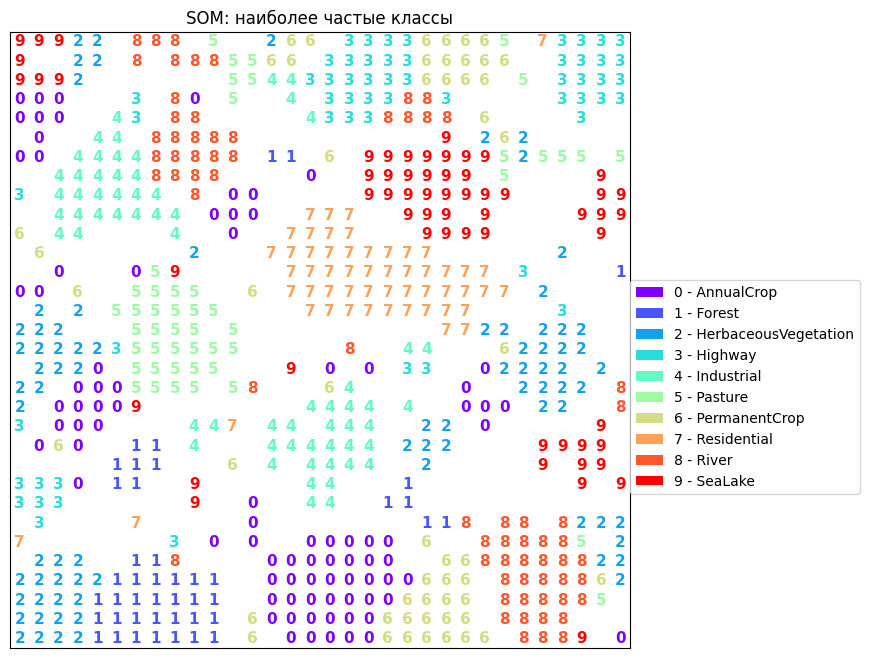

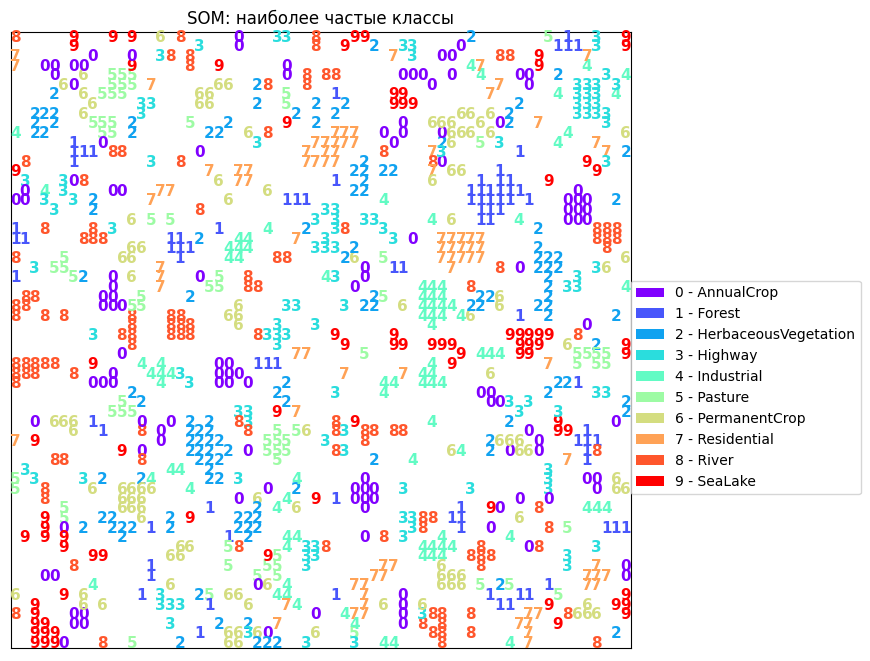

In [30]:
for cfg_name, som in som_trained.items():
    plot_som_legend_full(
        som=som,
        embeddings=embeddings_test,
        labels=labels_test,
        class_names=labels_dict,
        save_path=f"../resulting_images/som_{som.get_weights().shape[0]}x{som.get_weights().shape[1]}_most_freq_clses_on_test.png"
    )

### Генерация сравнения трейна и теста

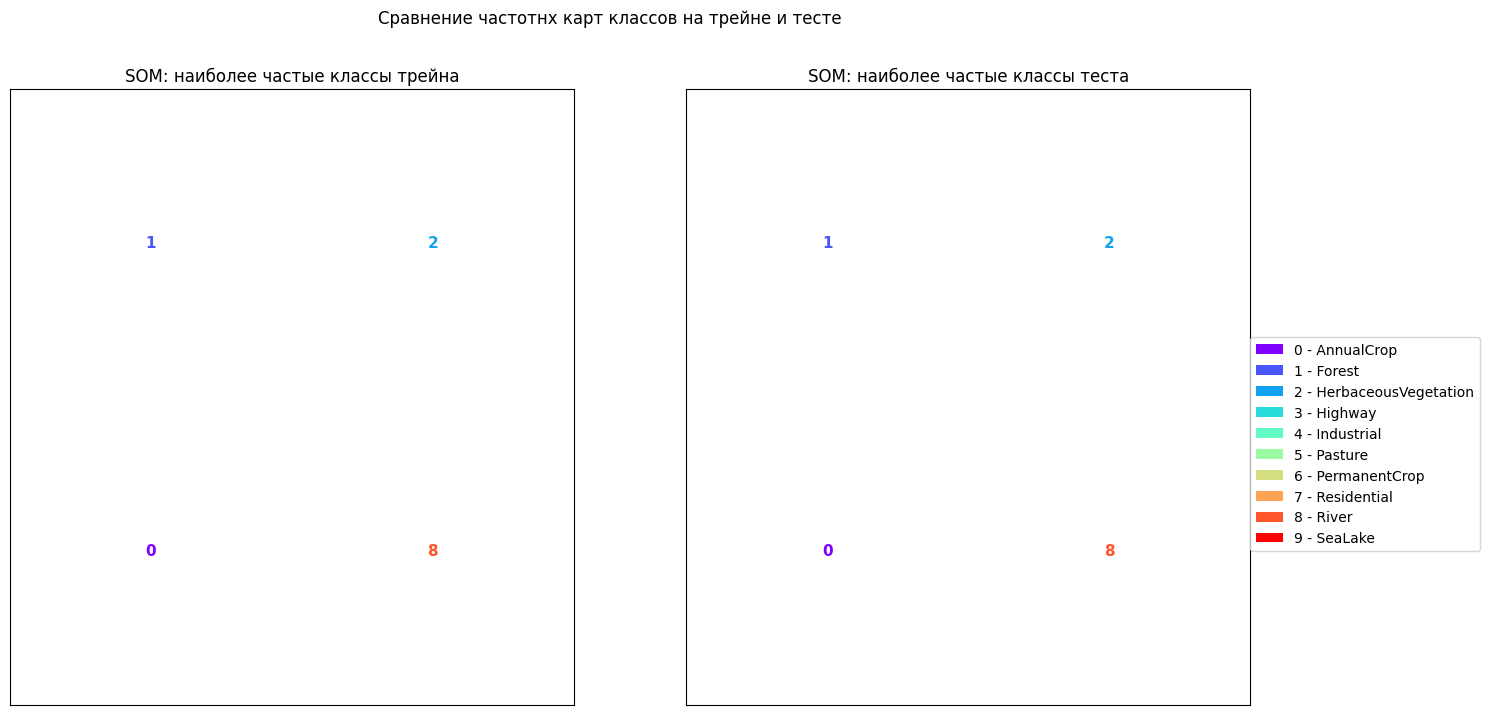

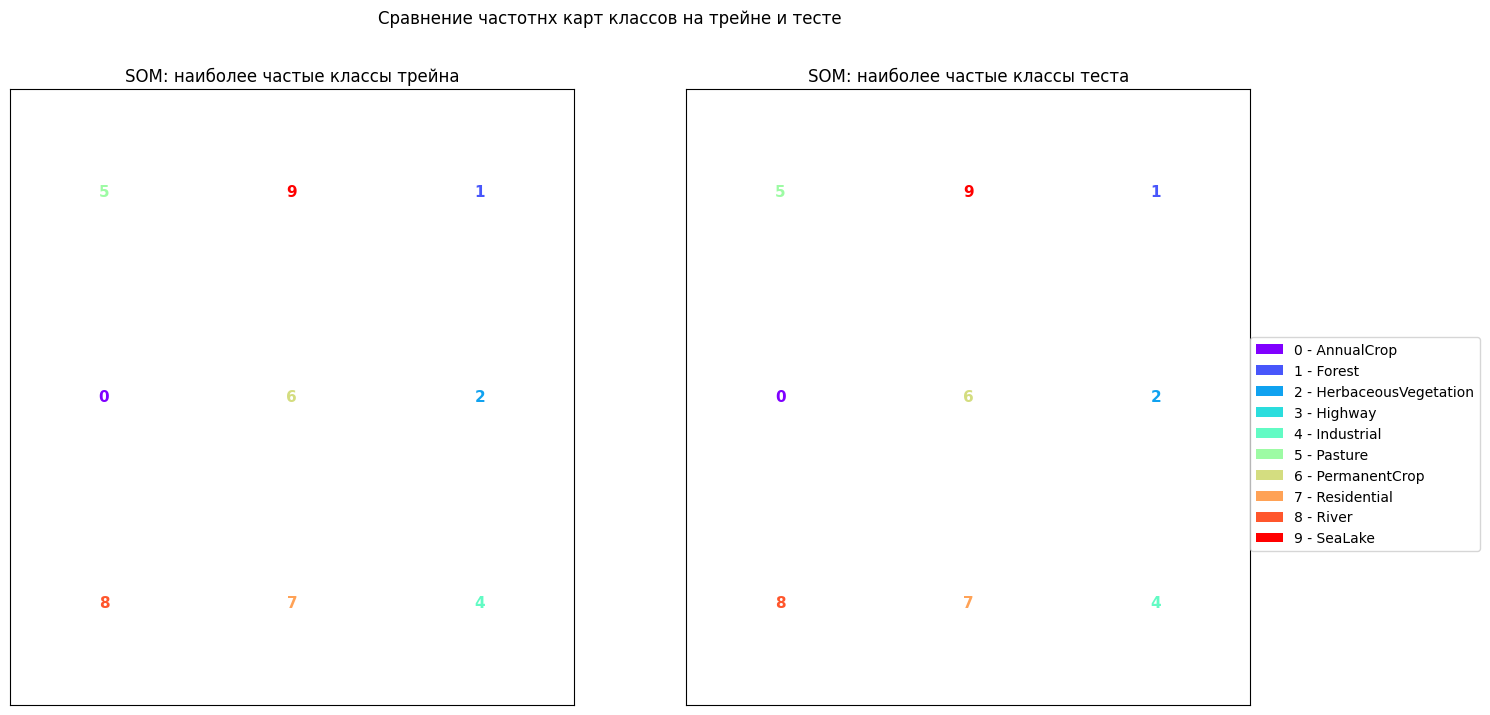

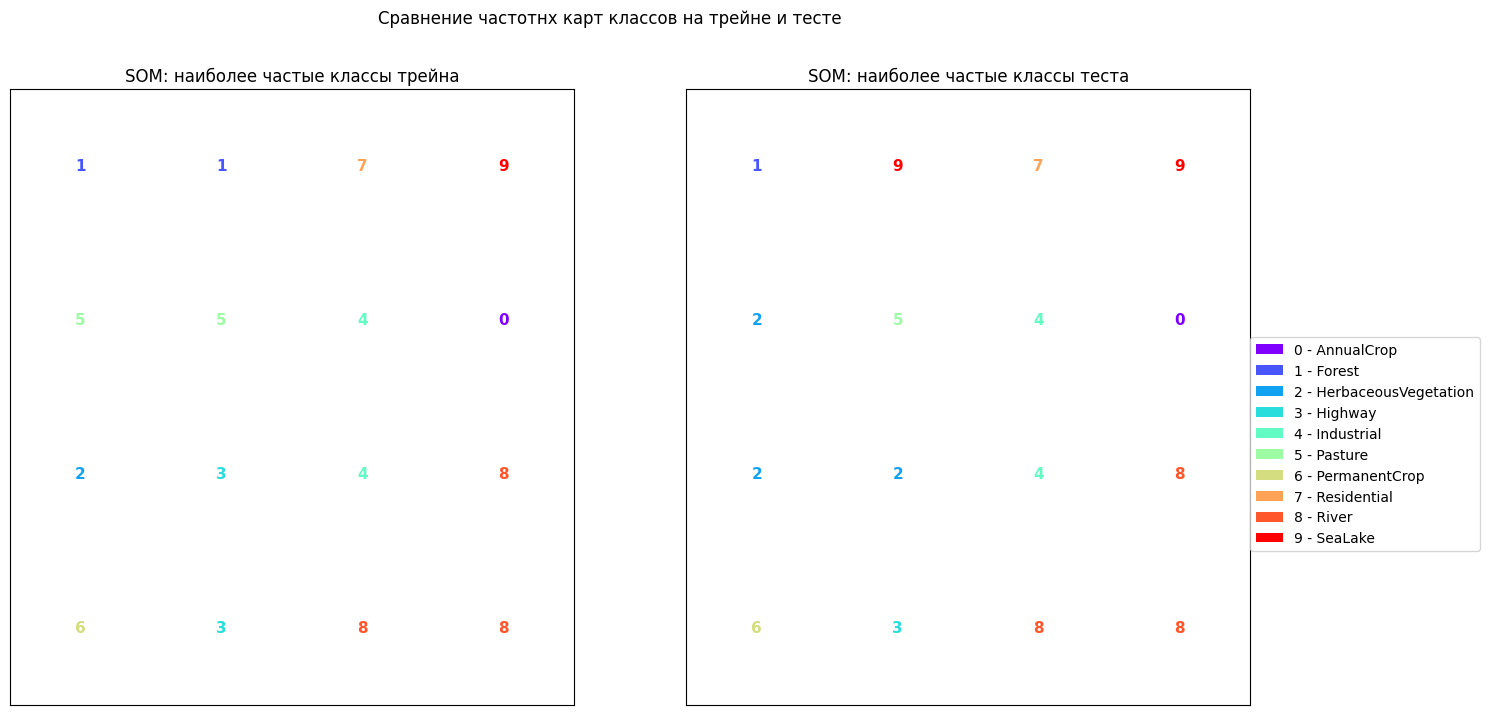

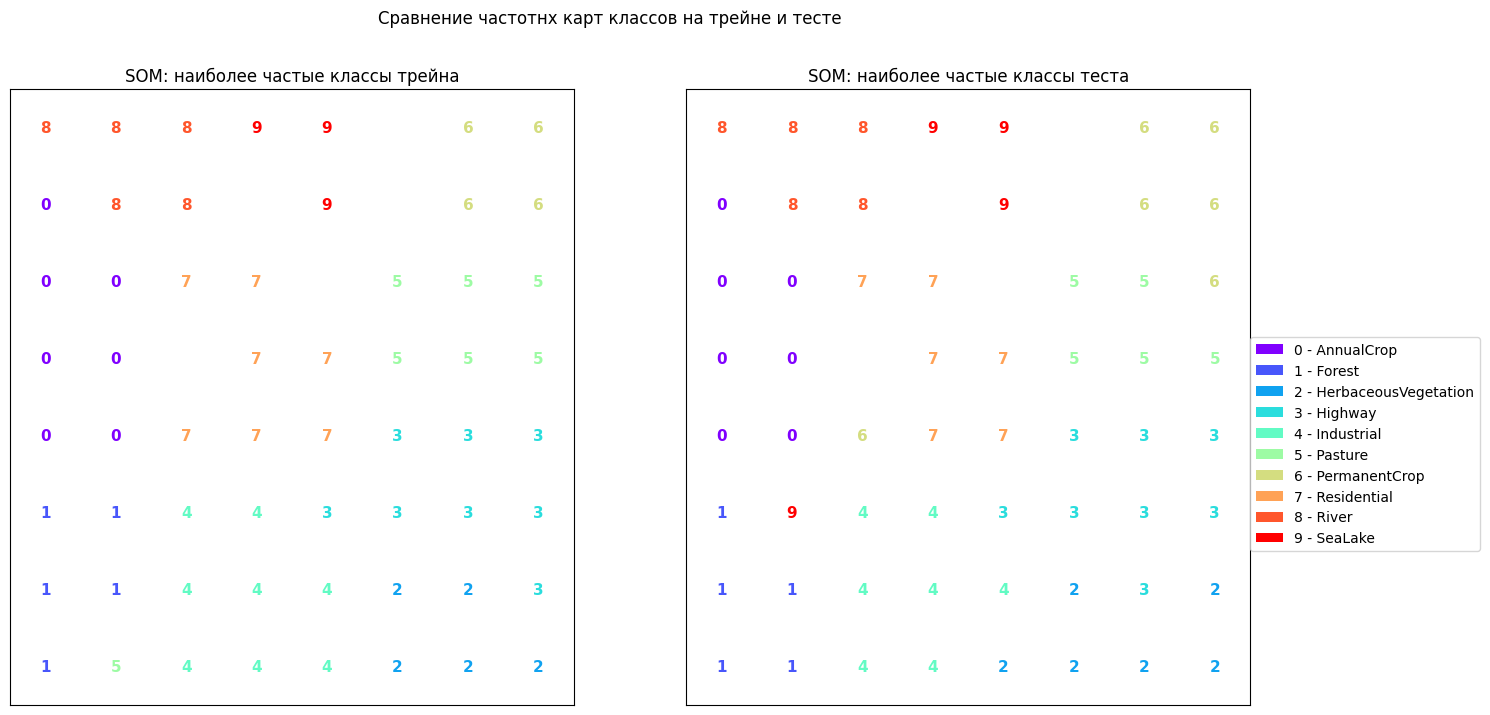

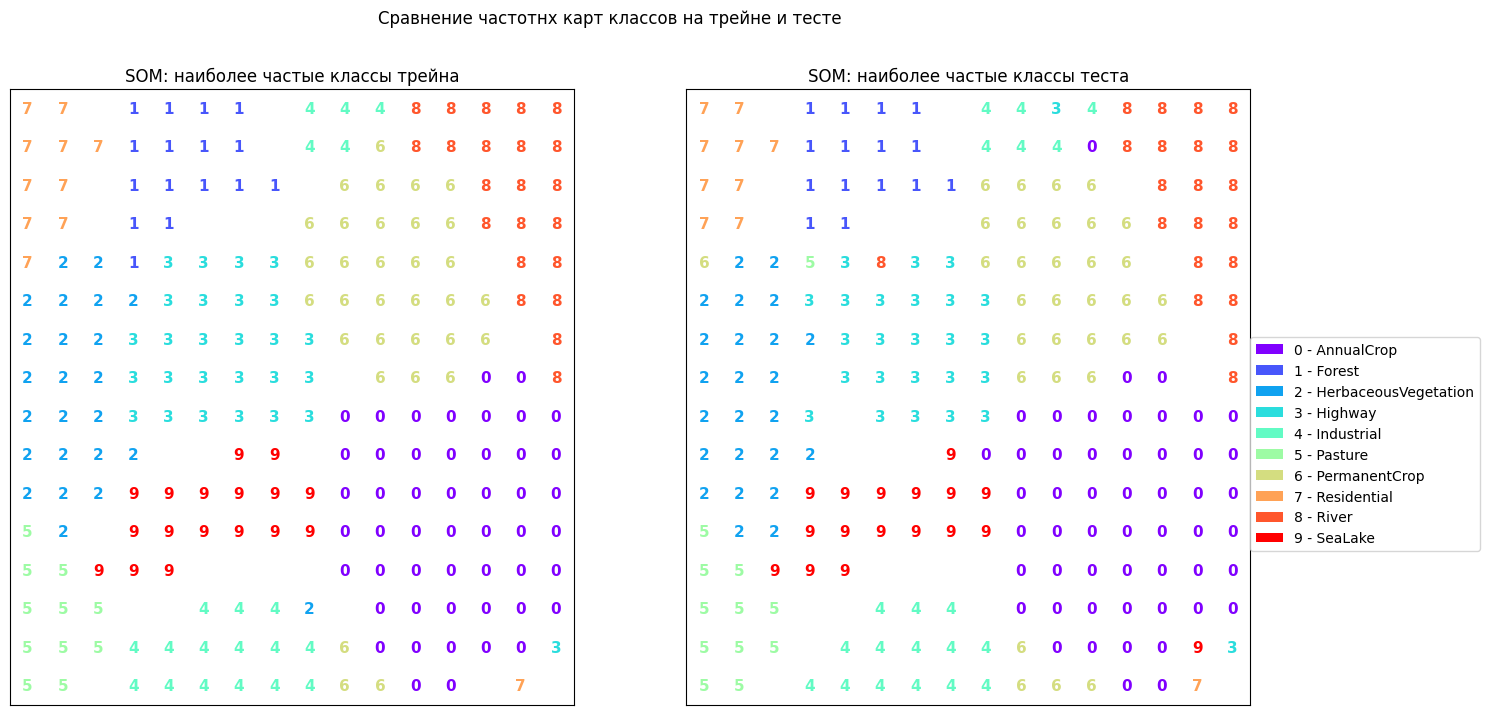

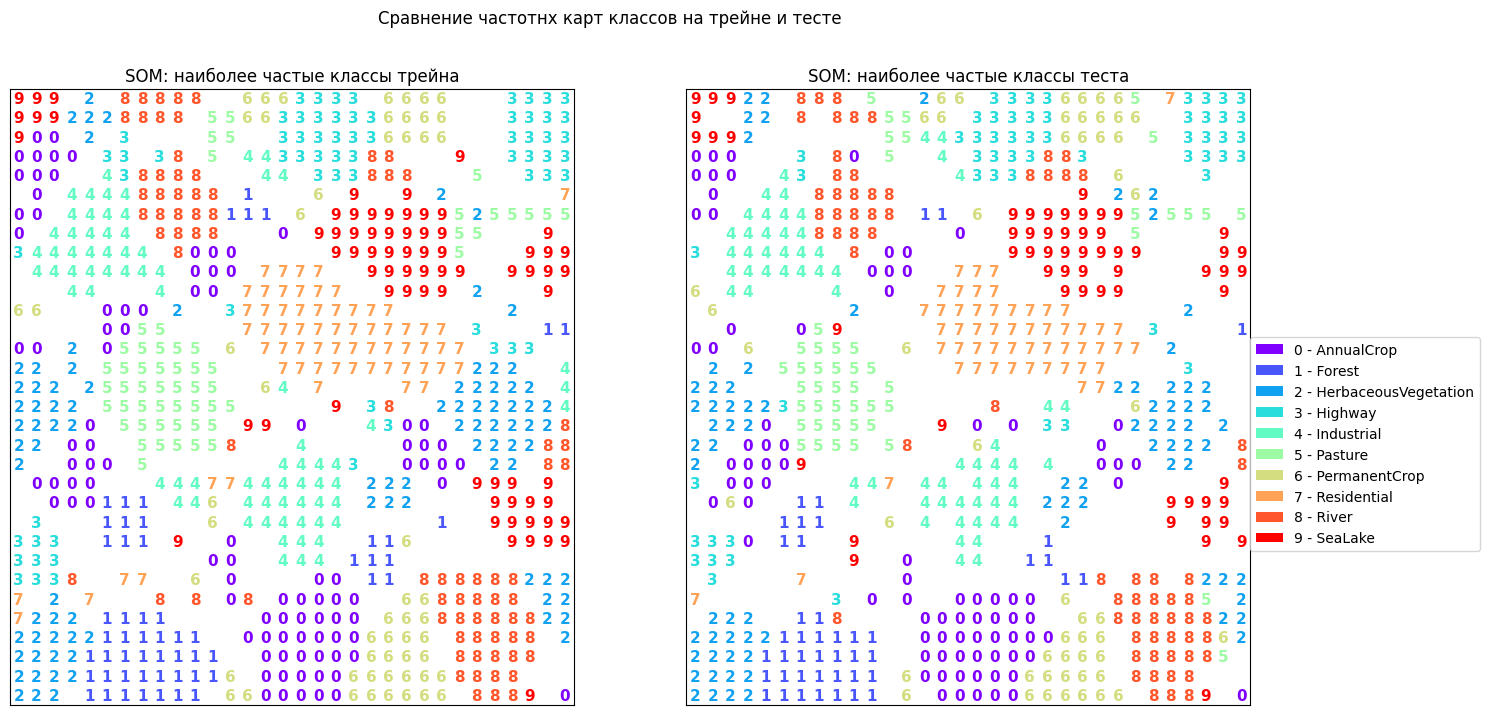

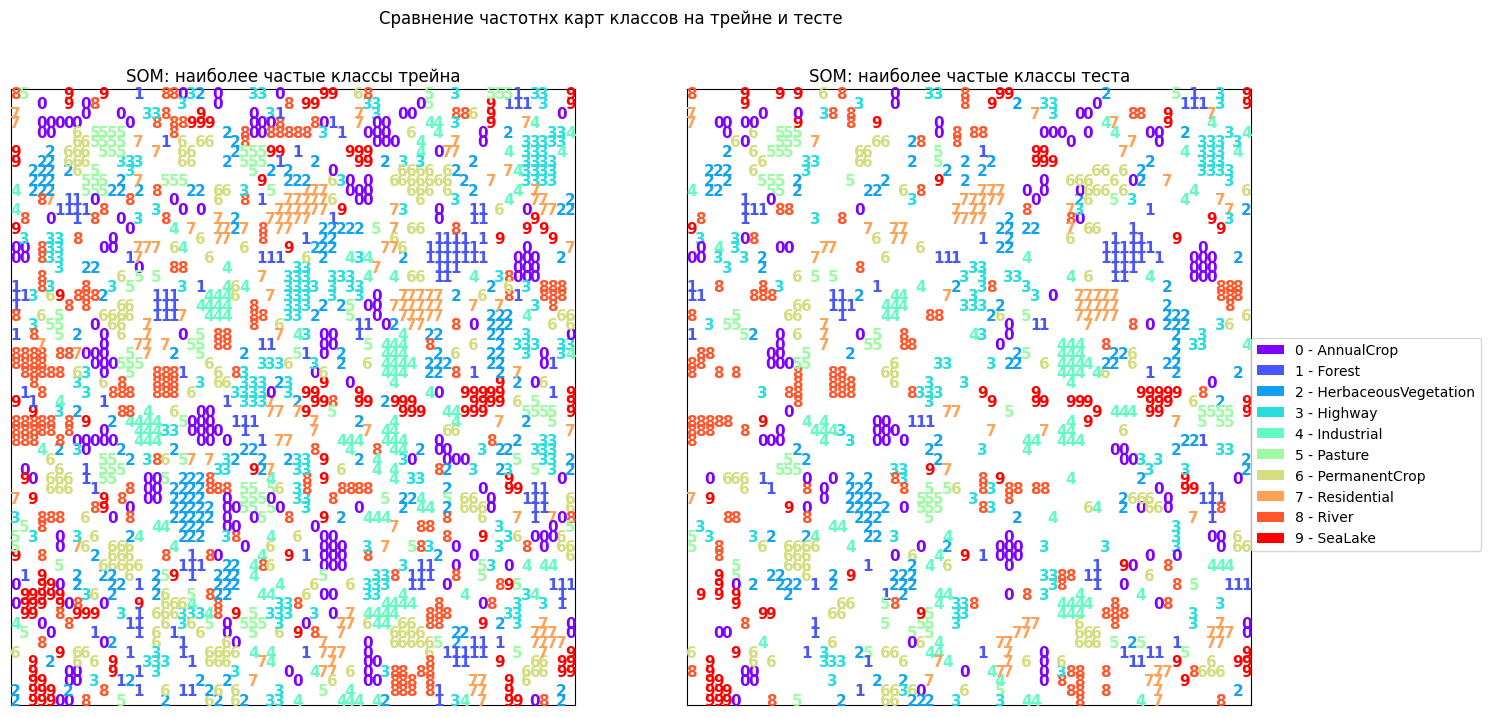

In [31]:
for cfg_name, som in som_trained.items():
    plot_som_comparison(
        som=som,
        embeddings_train=embeddings_train,
        labels_train=labels_train,
        embeddings_test=embeddings_test,
        labels_test=labels_test,
        class_names=labels_dict,
        save_path=f"../resulting_images/som_{som.get_weights().shape[0]}x{som.get_weights().shape[1]}_most_freq_clses_compare.png"
    )

## Функции для генерации карт с раскраской пикселей

Здесь просто ассоциируем каждй вектор карт с пикселем, после чего раскрашиваем пиксель на основе класса

Теперь две функции:

    - сравнение частот классов в элементамх карт
    - раскраска векторов карт по классам

In [39]:
def plot_som_diff_map(som, embeddings_train, labels_train, embeddings_test, labels_test, model, device, class_names=None, save_path=None):
    weights = som.get_weights()
    w_shape = weights.shape[:2]
    
    # объединение меток для корректного набора меток
    all_labels = np.concatenate([labels_train, labels_test])
    max_label = int(np.max(all_labels)) if len(all_labels) > 0 else 0
    
    # построение карты самых частых классов по нейронам
    # с маскированием нейронов ни разу не победивших
    def get_grid(emb, lbl):
        wmap = {}
        for x, t in zip(emb, lbl):
            wmap.setdefault(som.winner(x), []).append(t)
        
        grid = np.full(w_shape, -1)
        for pos, val_list in wmap.items():
            counts = Counter(val_list)
            # сортировка результатов подсчета лейблов (label, label_cnt), после чего берем 
            # лейбл самого частого значения
            winner = sorted(counts.items(), key=lambda x: (-x[1], x[0]))[0][0]
            grid[pos] = int(winner)
        return np.ma.masked_equal(grid, -1)

    # генерация карт самых частых классов по трейну и тесту
    grid_tr = get_grid(embeddings_train, labels_train)
    grid_te = get_grid(embeddings_test, labels_test)

    # здесь просто берем нейроны с карты Кохенена и раскрашииваем по классу
    w_flat = weights.reshape(-1, weights.shape[-1])
    with torch.no_grad():
        logits = model.classifier(torch.tensor(w_flat, dtype=torch.float32, device=device))
        grid_pred = torch.softmax(logits, axis=1).argmax(1).cpu().numpy().reshape(w_shape)

    # карта несовпадения самых частых классов
    common_mask = (~grid_tr.mask) & (~grid_te.mask)
    diff_data = np.full(w_shape, -1)
    
    if common_mask.any():
        # Сравниваем значения
        matches = (grid_tr[common_mask] == grid_te[common_mask]).astype(int)
        diff_data[common_mask] = matches
        
    grid_diff = np.ma.masked_equal(diff_data, -1)

    # --- Визуализация ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Палитра классов
    cmap_cls = plt.cm.rainbow.copy()
    cmap_cls.set_bad('white') # Пустые клетки белые
    norm_cls = mcolors.Normalize(vmin=0, vmax=max_label)

    # Палитра различий: 0 -> Red, 1 -> Green
    cmap_diff = mcolors.ListedColormap(['red', 'green'])
    cmap_diff.set_bad('white')
    # !ВАЖНО! Фиксируем норму 0..1, иначе при полном совпадении (все 1) mpl сделает всё красным
    norm_diff = mcolors.Normalize(vmin=0, vmax=1) 

    plots = [
        (axes[0,0], grid_tr, "Train: частотные классы", cmap_cls, norm_cls),
        (axes[0,1], grid_te, "Test: частотные классы", cmap_cls, norm_cls),
        (axes[1,0], grid_pred, "Model: классификация весов", cmap_cls, norm_cls),
        (axes[1,1], grid_diff, "Diff: Green=Match, Red=Mismatch", cmap_diff, norm_diff)
    ]

    for ax, data, title, cm, nm in plots:
        ax.imshow(data.T, cmap=cm, norm=nm, origin='upper')
        ax.set_title(title)
        ax.axis("off")

    # создание легенды по классам
    if class_names:
        inv_names = {v: k for k, v in class_names.items()} if isinstance(list(class_names.keys())[0], str) else class_names
        handles = [Patch(color=cmap_cls(k/max_label), label=f"{k}-{inv_names.get(k, k)}") 
                   for k in sorted(inv_names) if k <= max_label]
        axes[0,1].legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=9)

    fig.suptitle(f"SOM {w_shape[0]}x{w_shape[1]} Comparison")
    plt.tight_layout()
    if save_path: plt.savefig(save_path, bbox_inches='tight')
    plt.show()

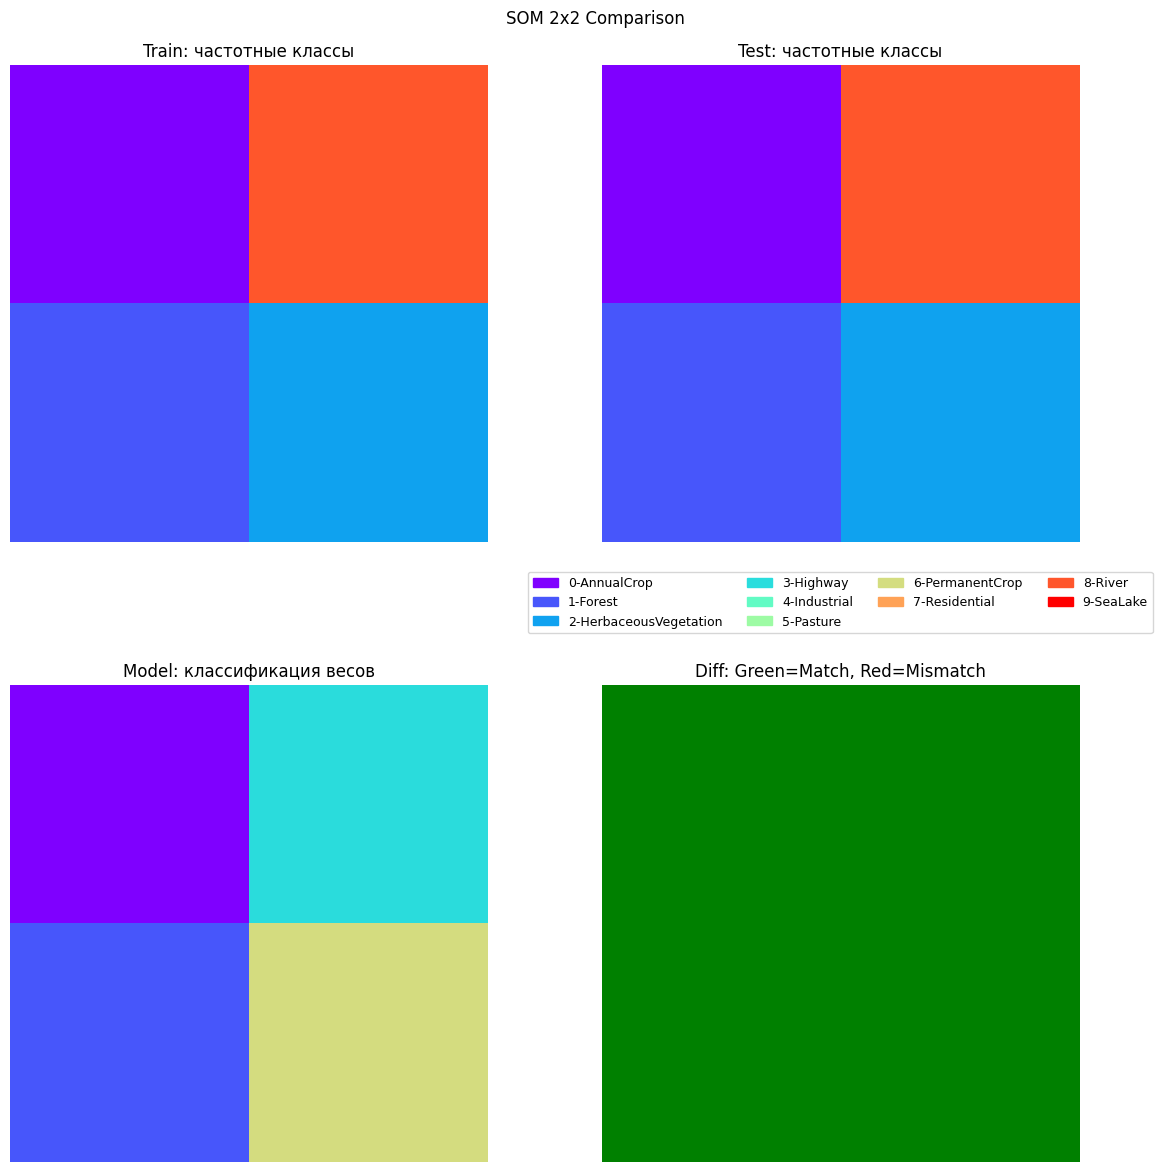

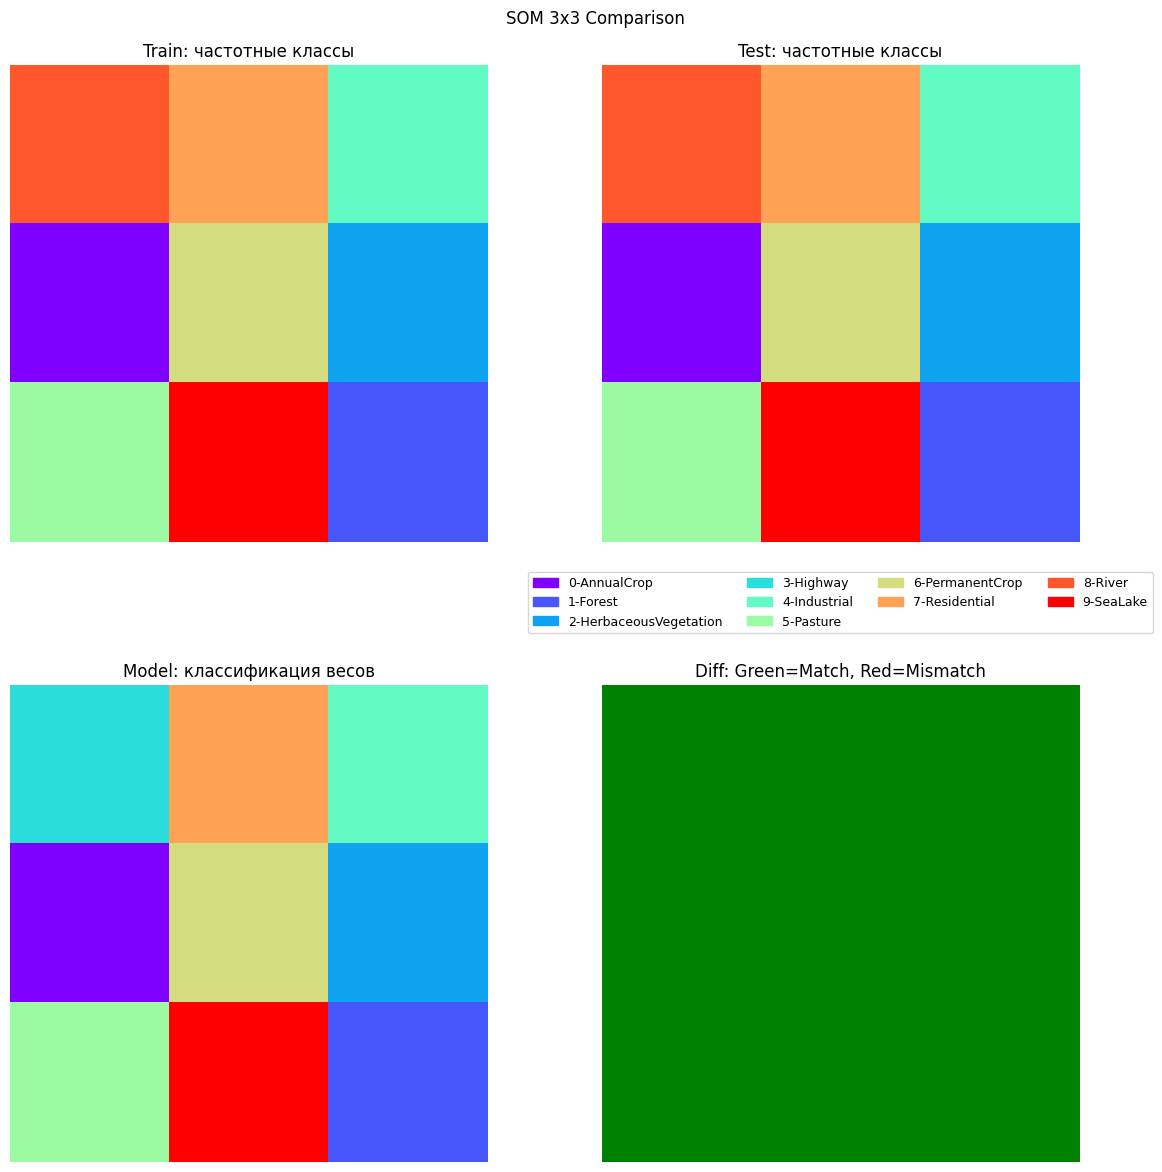

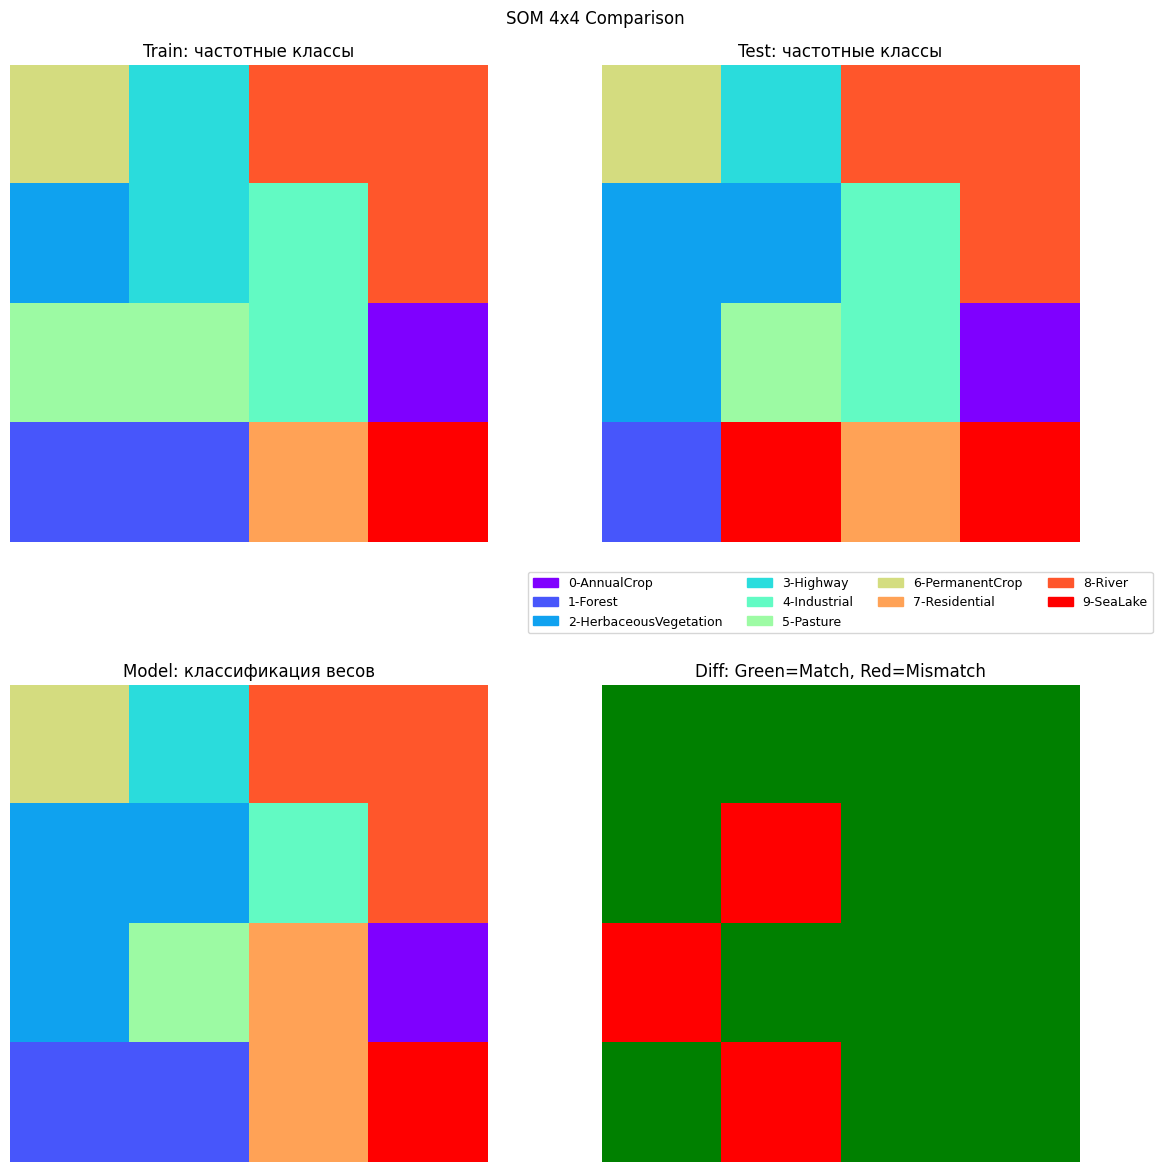

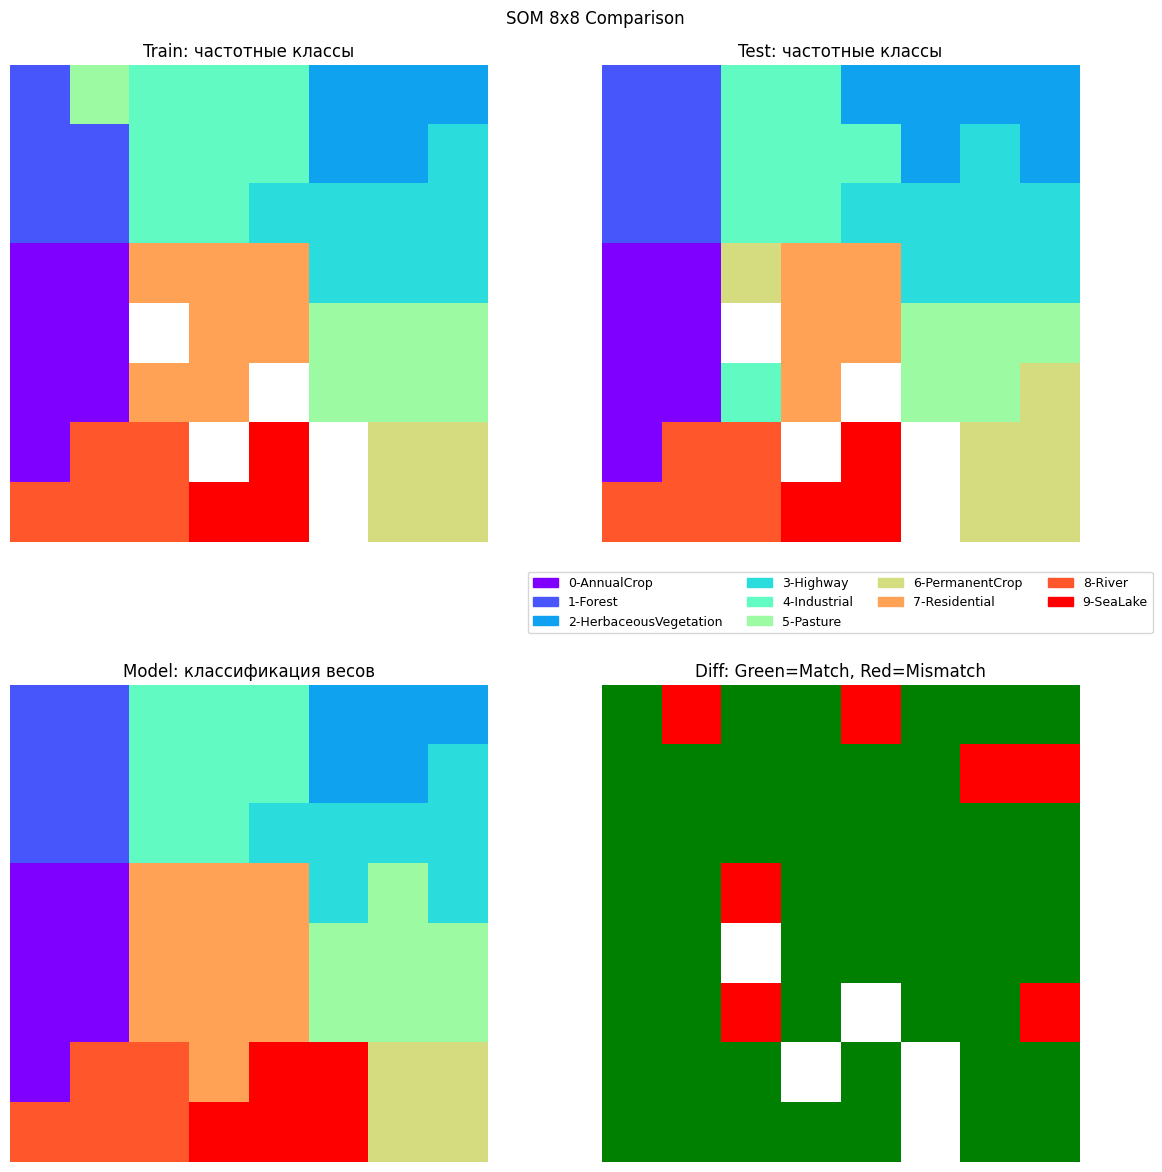

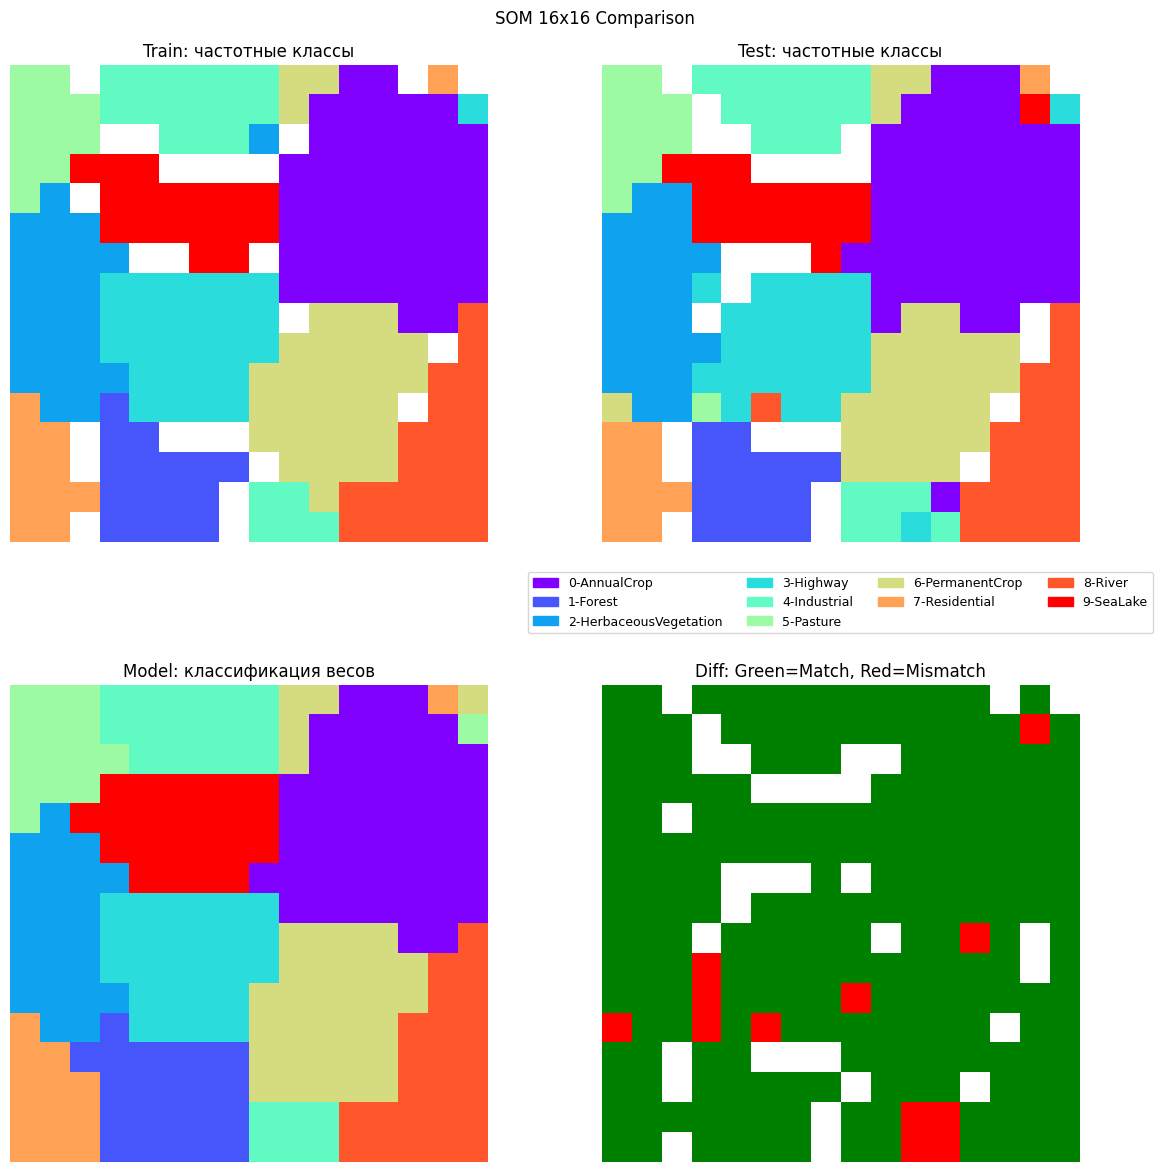

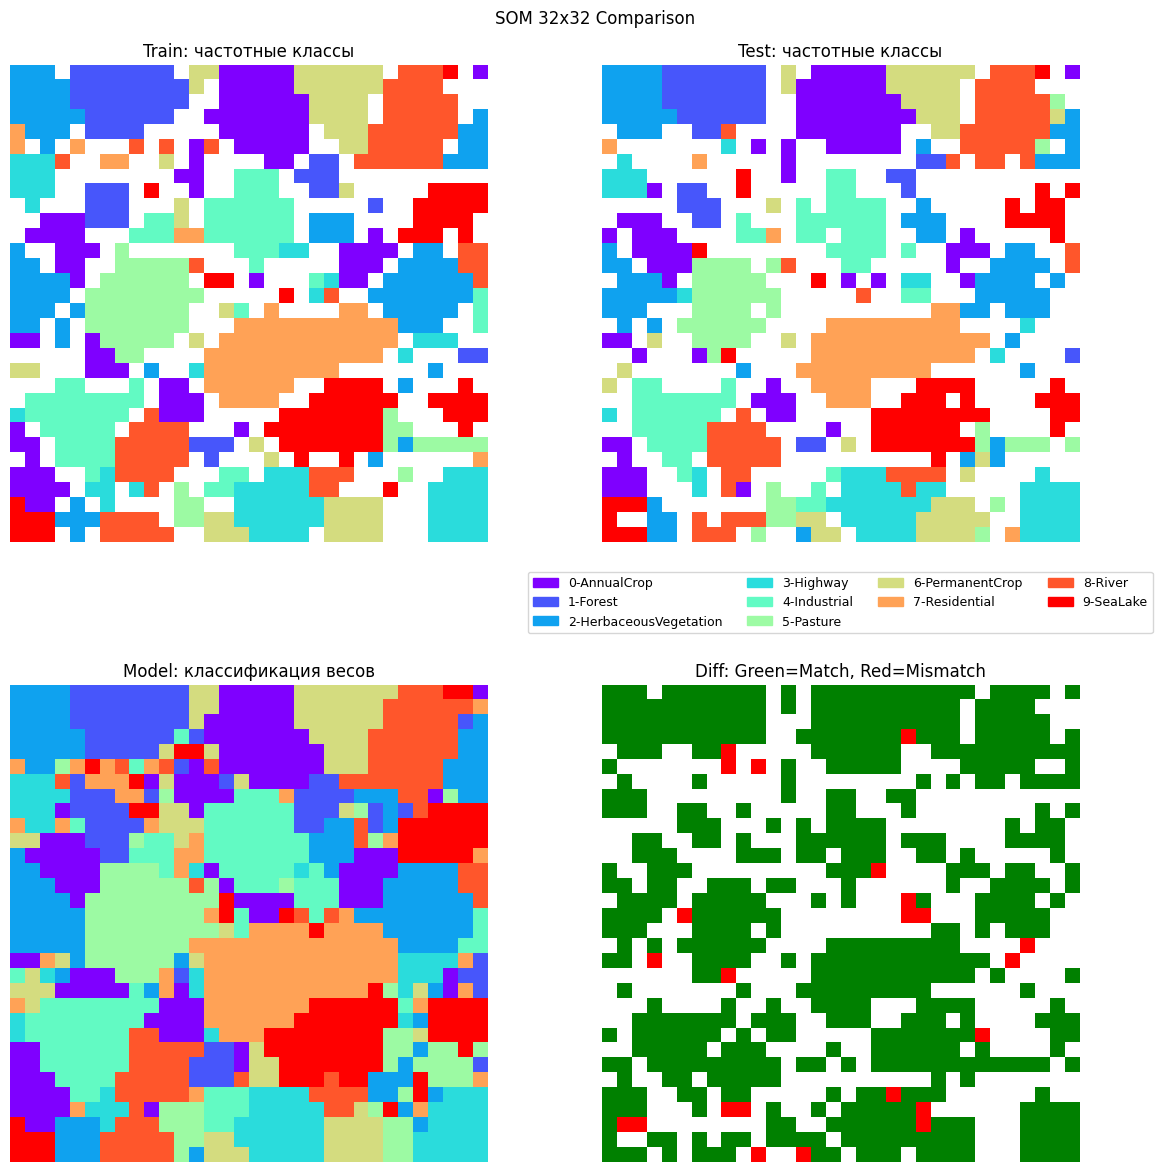

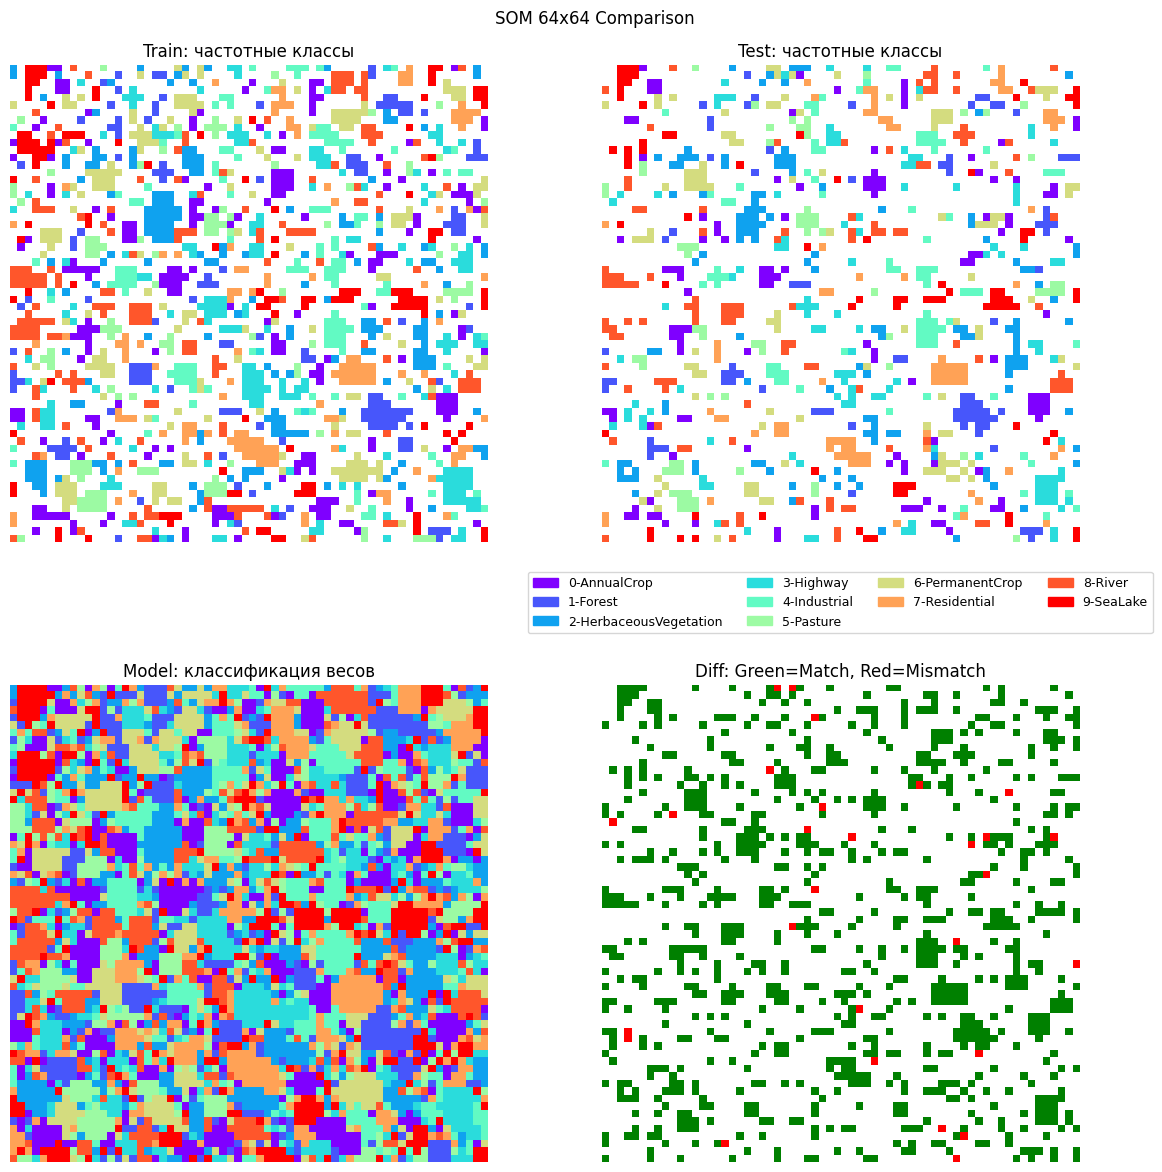

In [40]:
for cfg_name, som in som_trained.items():
    plot_som_diff_map(
        som=som,
        embeddings_train=embeddings_train,
        labels_train=labels_train,
        embeddings_test=embeddings_test,
        labels_test=labels_test,
        class_names=labels_dict,
        save_path=f"../resulting_images/som_{som.get_weights().shape[0]}x{som.get_weights().shape[1]}_freq_pic_comparison.png",
        model=model,
        device=device
    )

# Карта топ победителей для каждого класса

Перебор классов:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/3 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

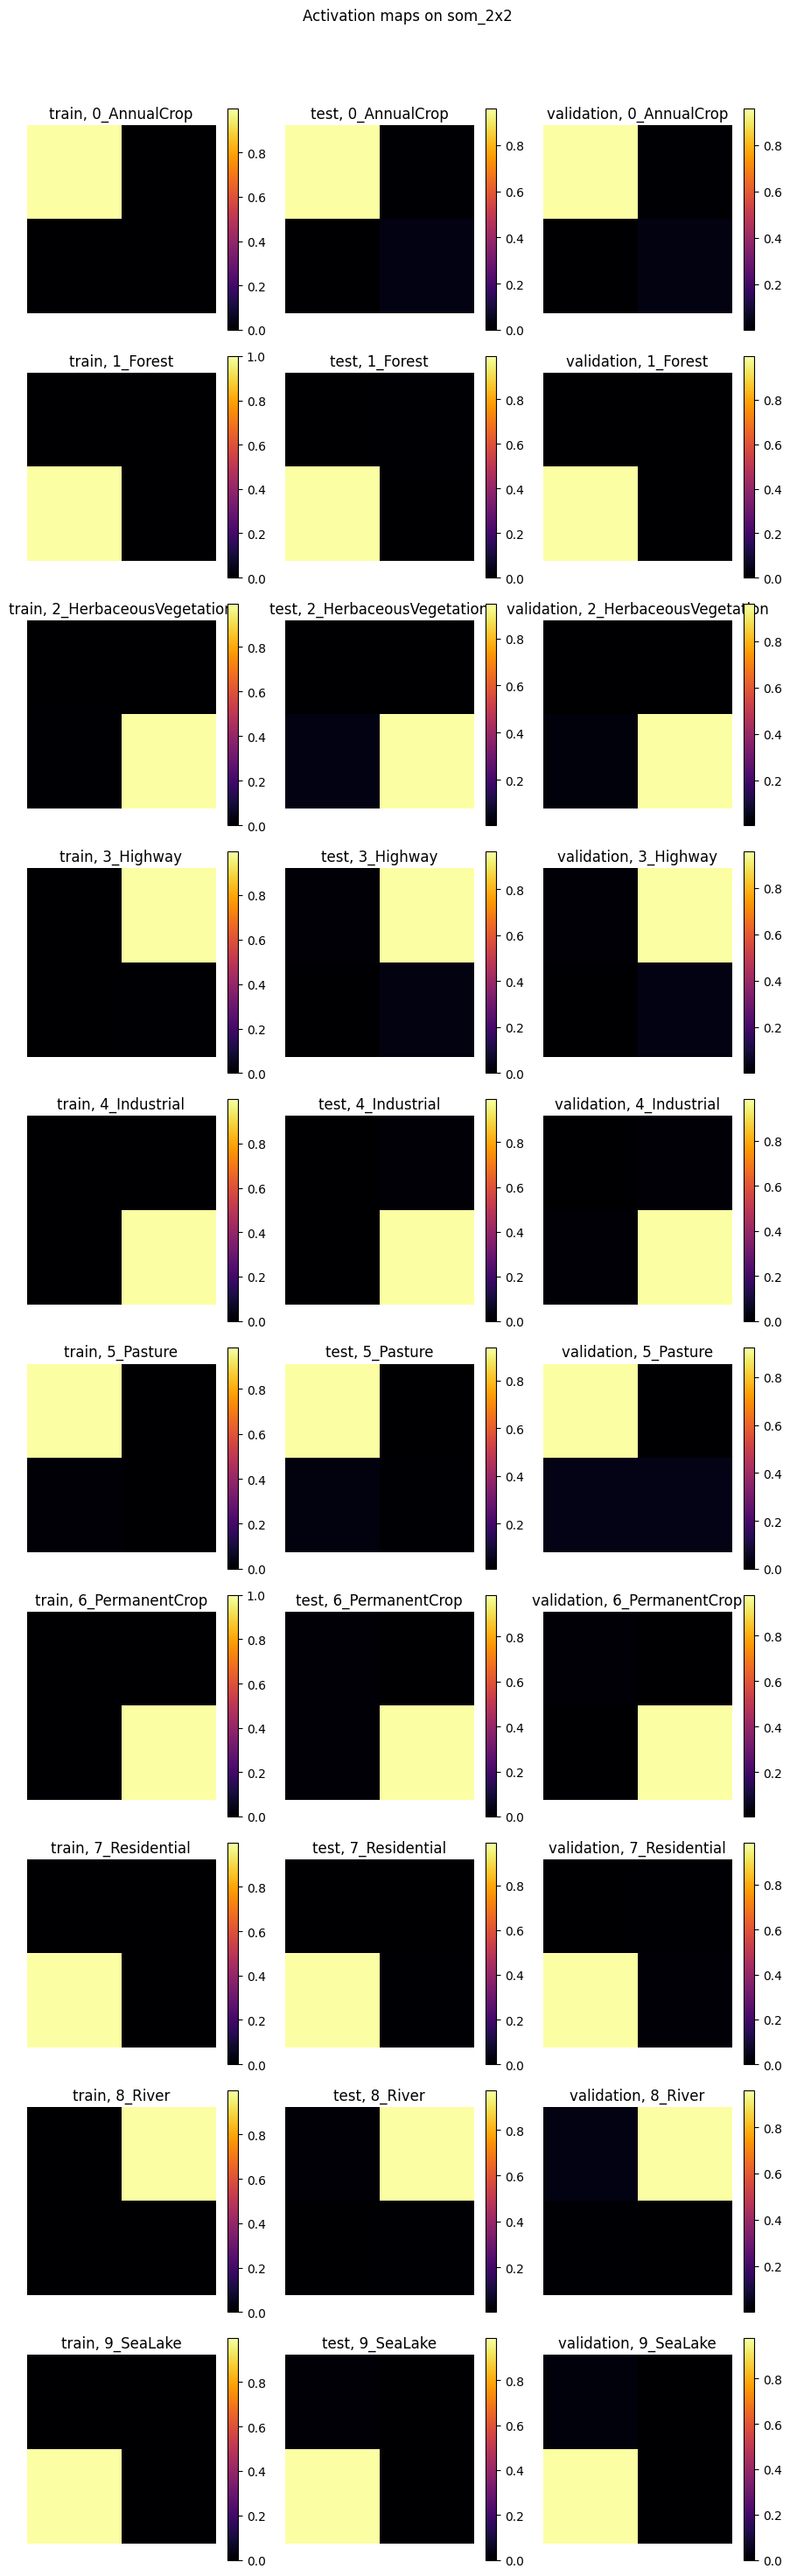

Перебор классов:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/3 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

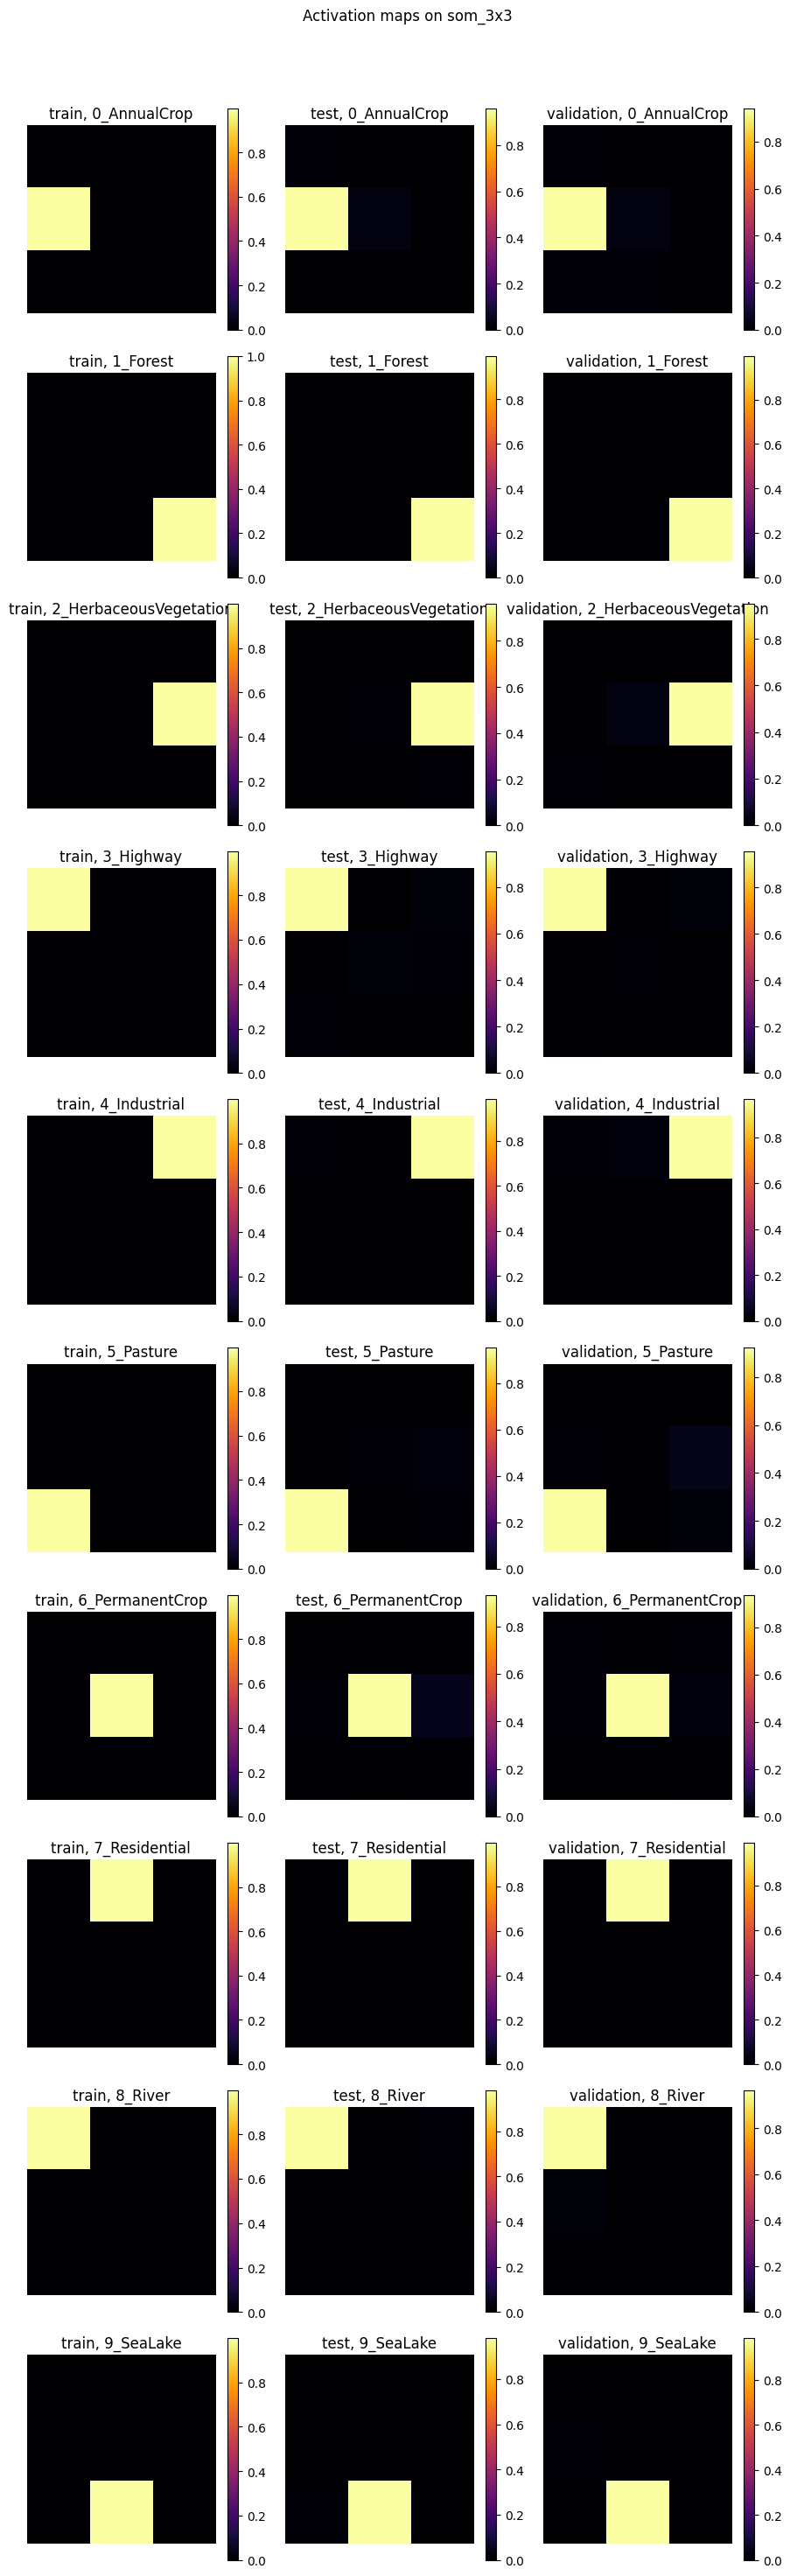

Перебор классов:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/3 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

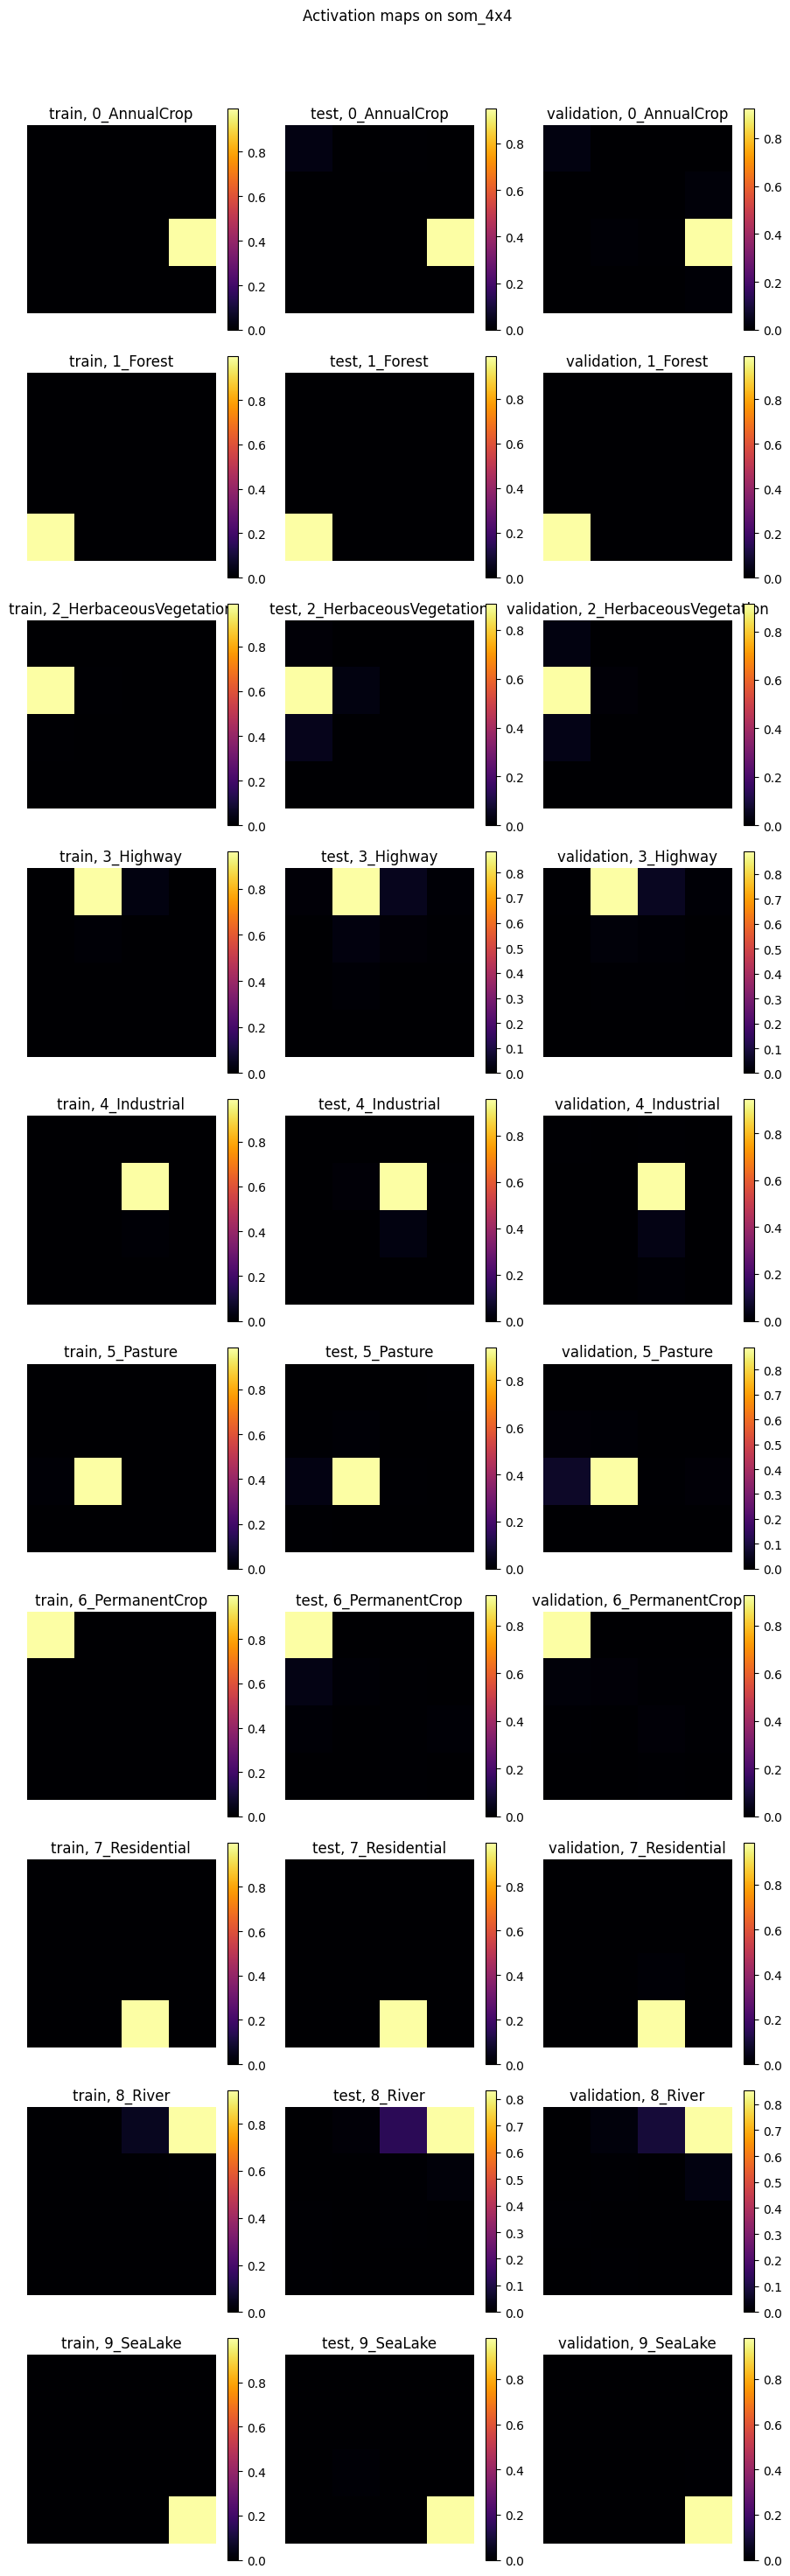

Перебор классов:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/3 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

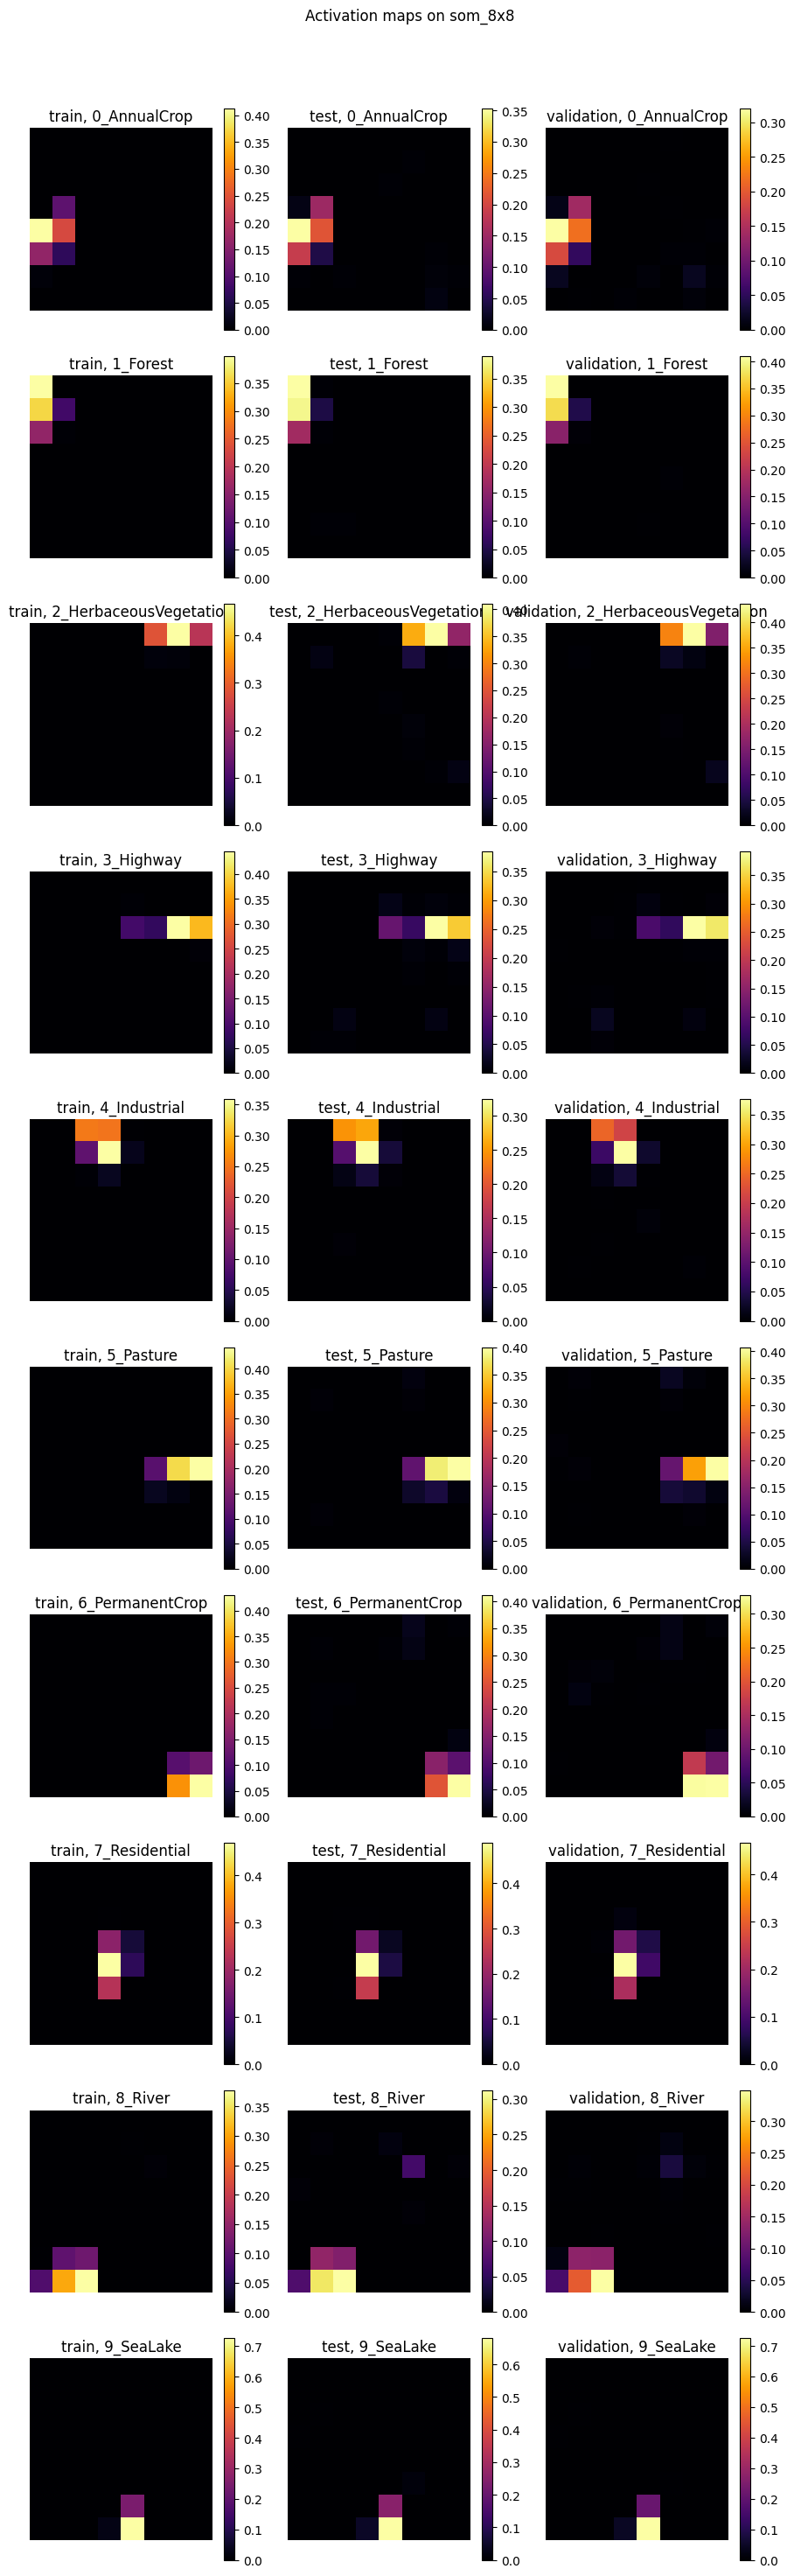

Перебор классов:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/3 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

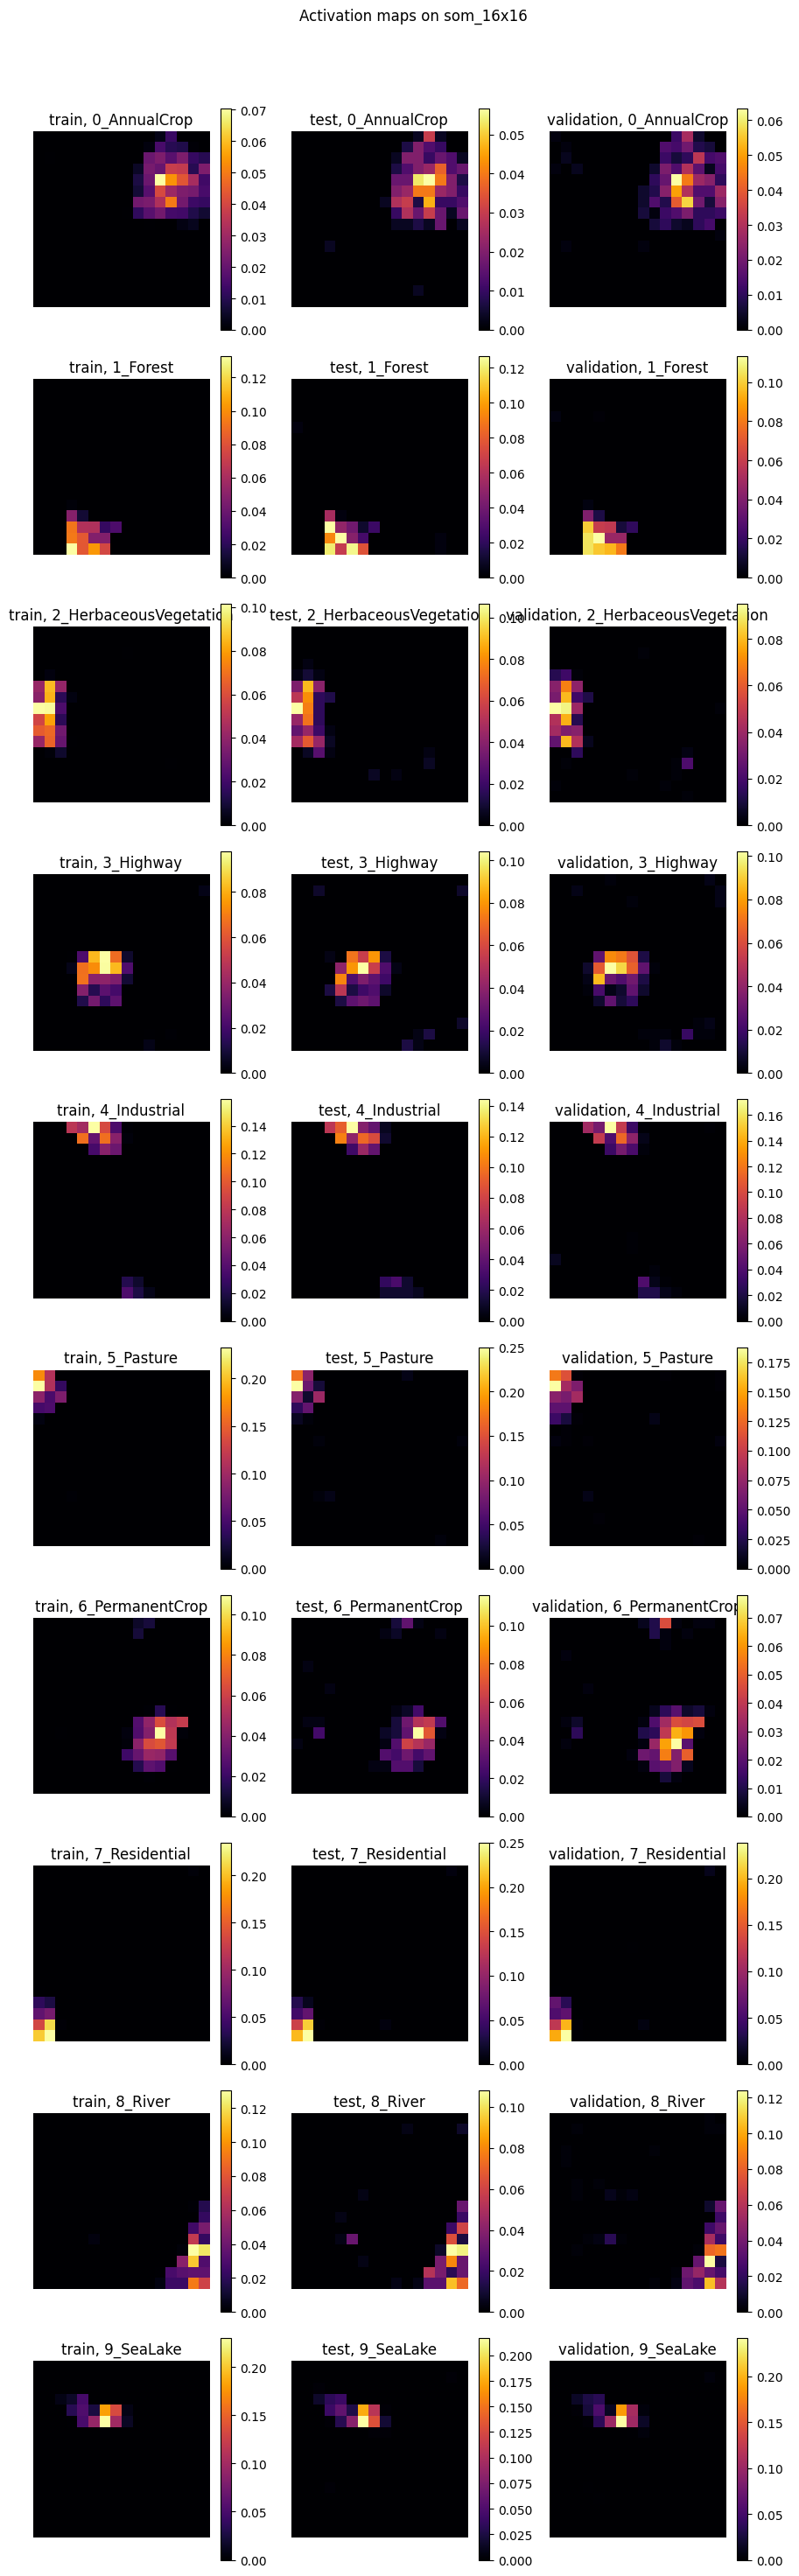

Перебор классов:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/3 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

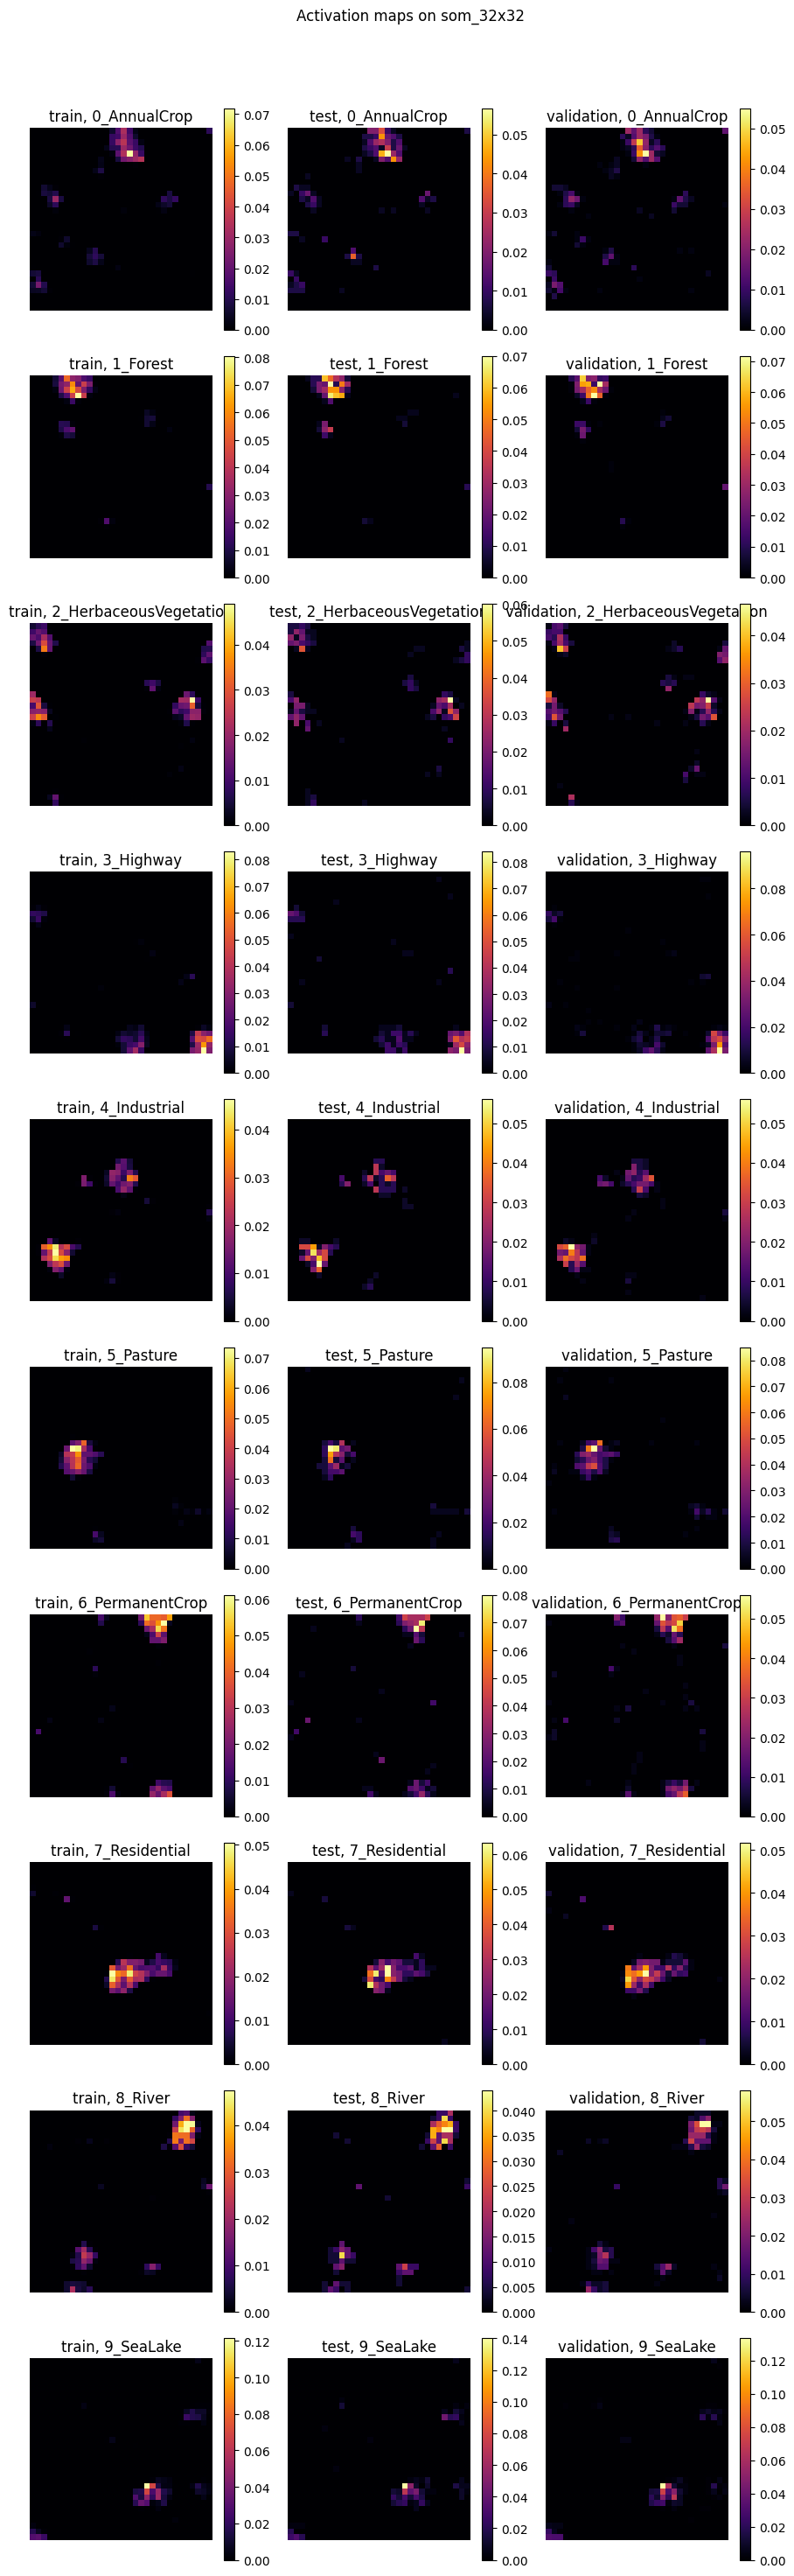

Перебор классов:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/3 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/4 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through datasets: 0it [00:00, ?it/s]

Iterating through batches(train):   0%|          | 0/5 [00:00<?, ?it/s]

Iterating through batches(test):   0%|          | 0/1 [00:00<?, ?it/s]

Iterating through batches(validation):   0%|          | 0/2 [00:00<?, ?it/s]

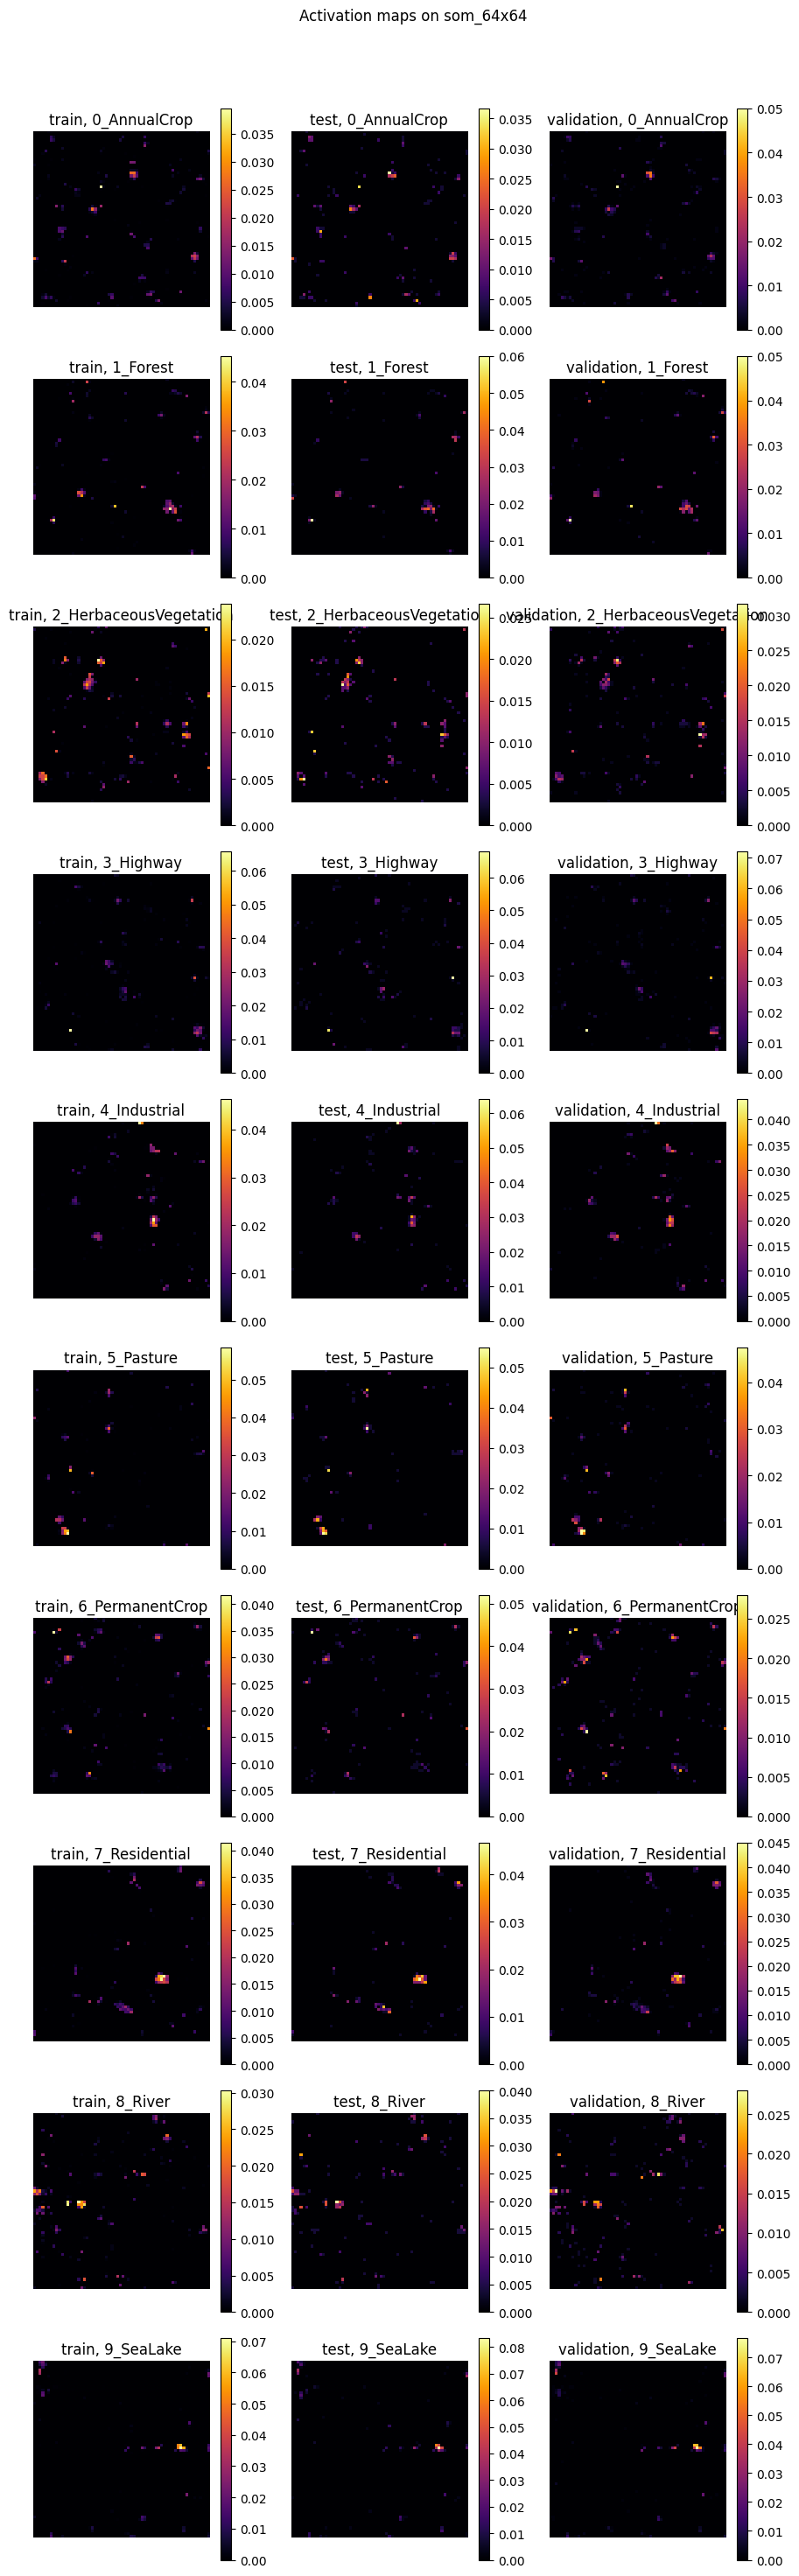

In [50]:
for cfg_name, som in som_trained.items():
    fig, ax = plt.subplots(10, 3, figsize=(9, 30))
    fig.suptitle(f"Activation maps on som_{som.get_weights().shape[0]}x{som.get_weights().shape[1]}")
    
    for cl, cl_name in tqdm(inv_labels_dict.items(), desc="Перебор классов", leave=False):
        ds_types = enumerate(["train", "test", "validation"])
        for i, ds_type in tqdm(ds_types, desc="Iterating through datasets", leave=False):
            ds = EuroSATDataset(Path(img_path) / f"{ds_type}.csv", img_path, cl, True)
            dl = DataLoader(ds, batch_size=512, shuffle=False)
            
            emb_cl = []
            for batch in tqdm(dl, desc=f"Iterating through batches({ds_type})", leave=False):
                x = batch[0]
                with torch.no_grad():
                    logits, emb = model(x.to(device))
                    logits = logits.cpu()
                    emb = emb.cpu()
                    emb_cl.append(emb)
            
            emb_cl = np.concat(emb_cl, axis=0)
            freq_img = som.activation_response(emb_cl) / len(ds)
    
            act_img = ax[cl, i].imshow(freq_img.T, origin="upper", cmap=plt.cm.inferno)
            fig.colorbar(act_img, ax=ax[cl, i])
            ax[cl, i].axis("off")
            ax[cl, i].set(title=f"{ds_type}, {cl}_{cl_name}")
            
    
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(f"../resulting_images/activation_maps_on_classes_som_{som.get_weights().shape[0]}x{som.get_weights().shape[1]}.png")
    plt.show()

# Подача своих данных и визуализация результата

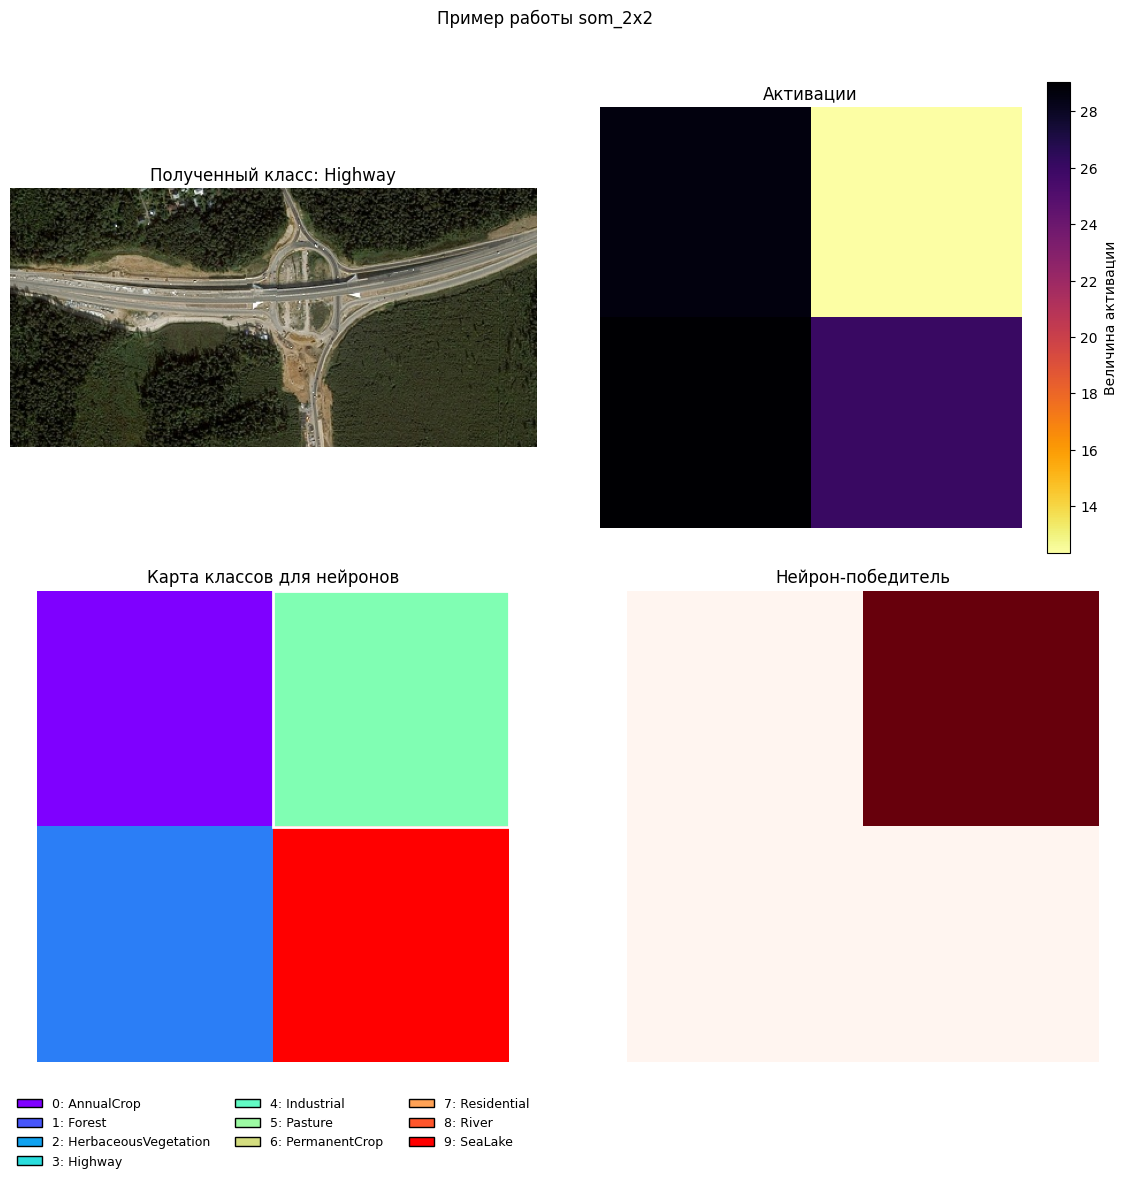

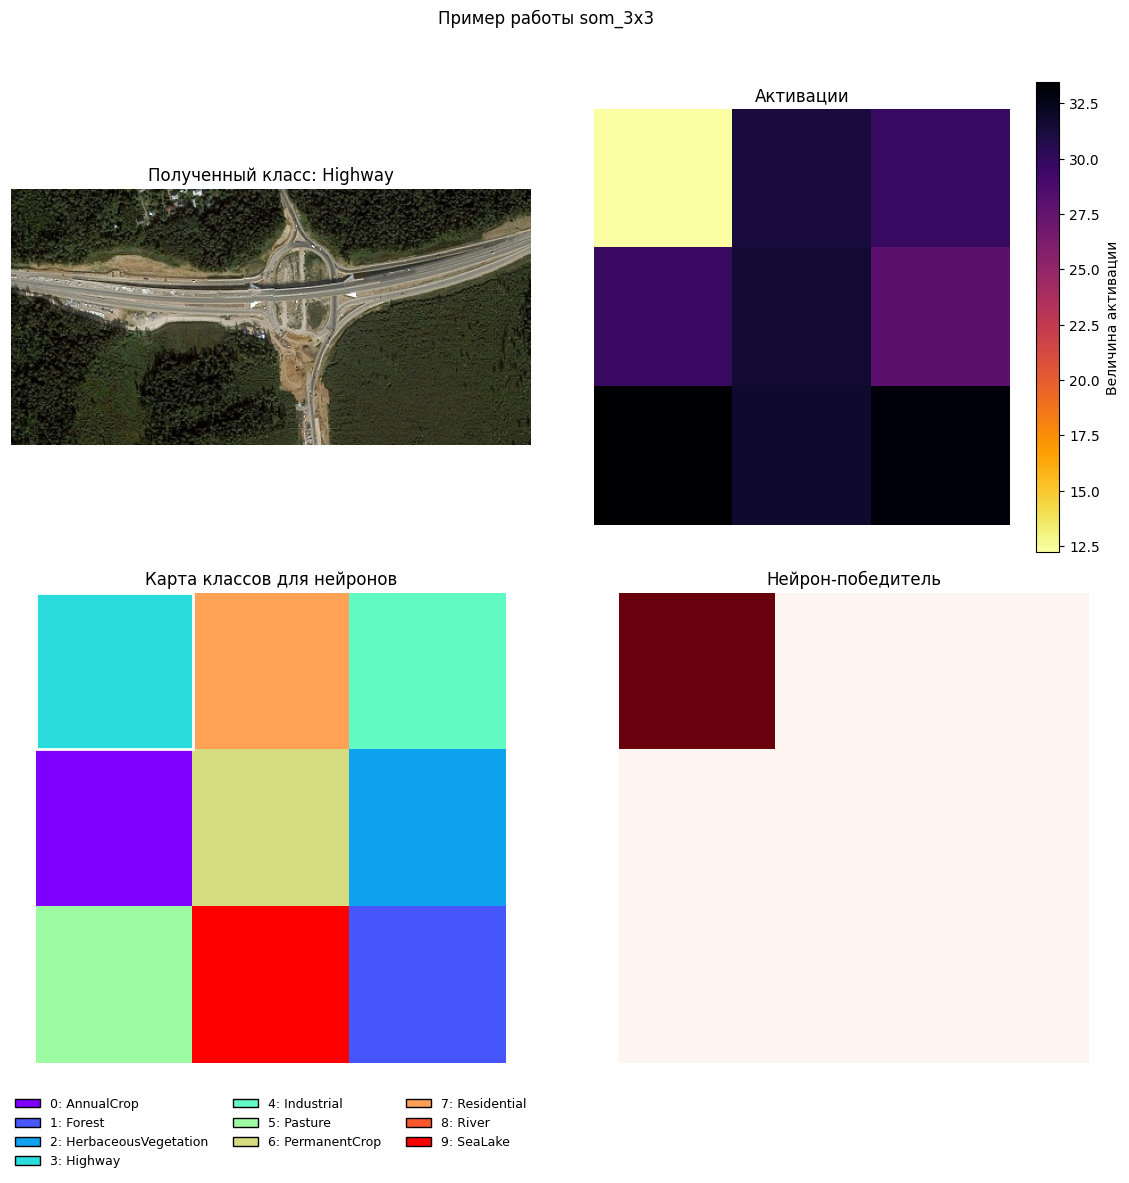

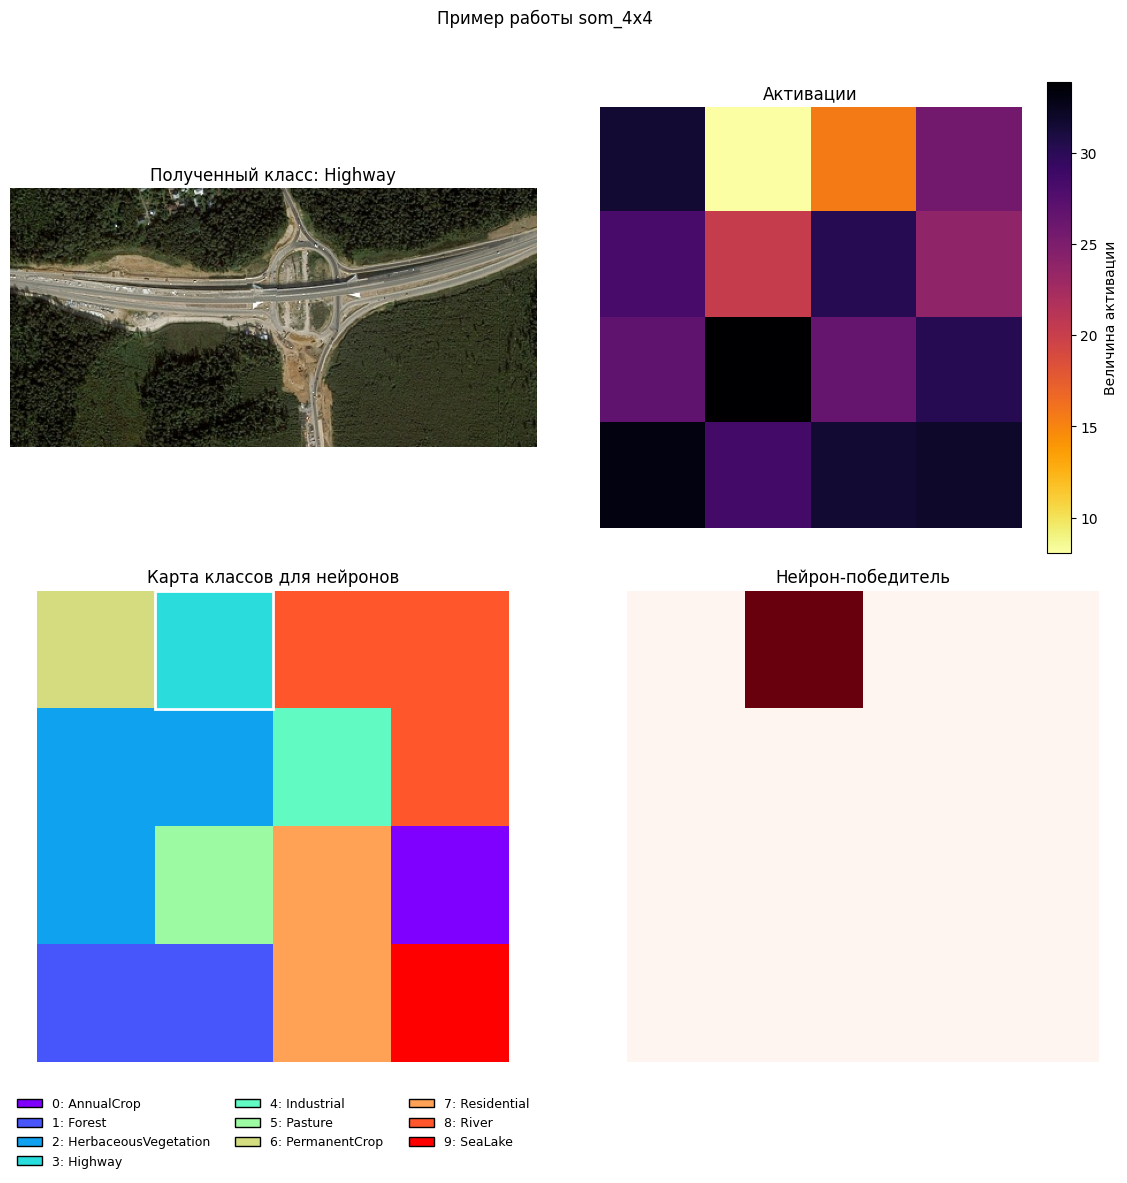

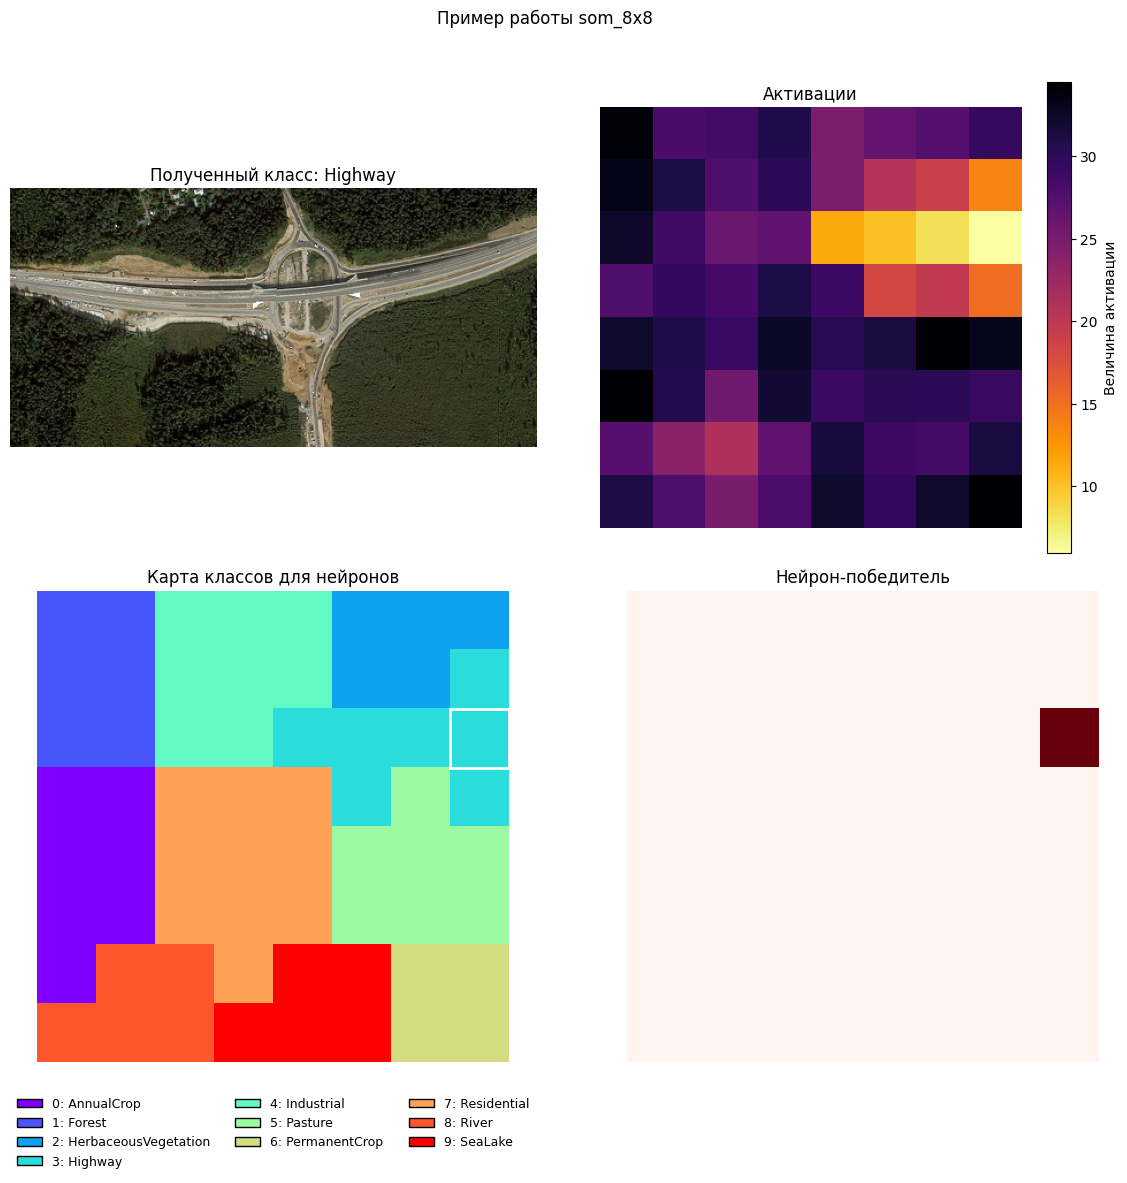

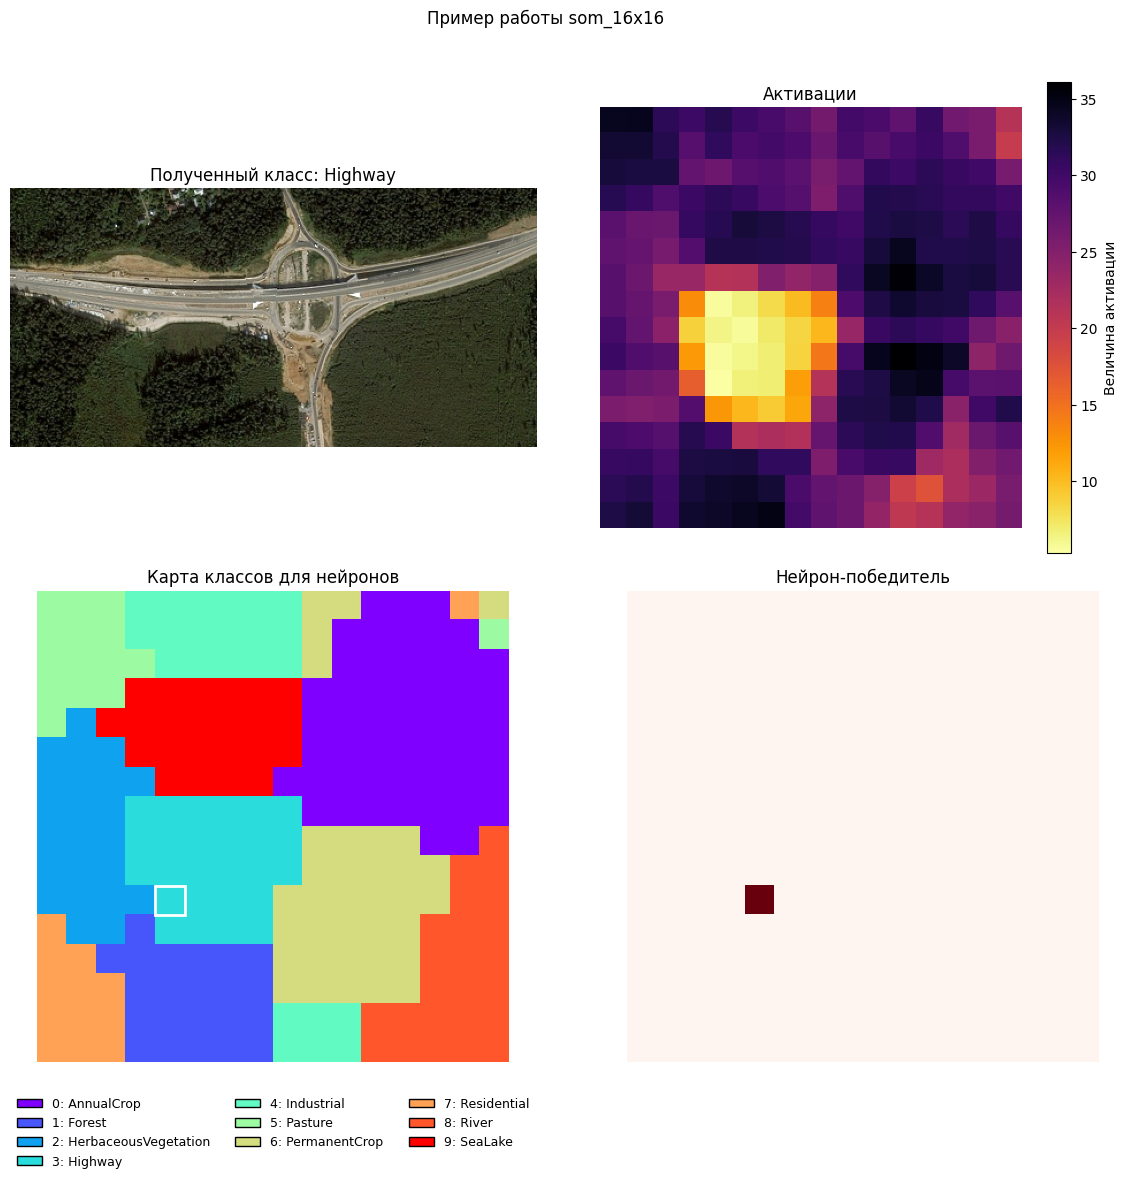

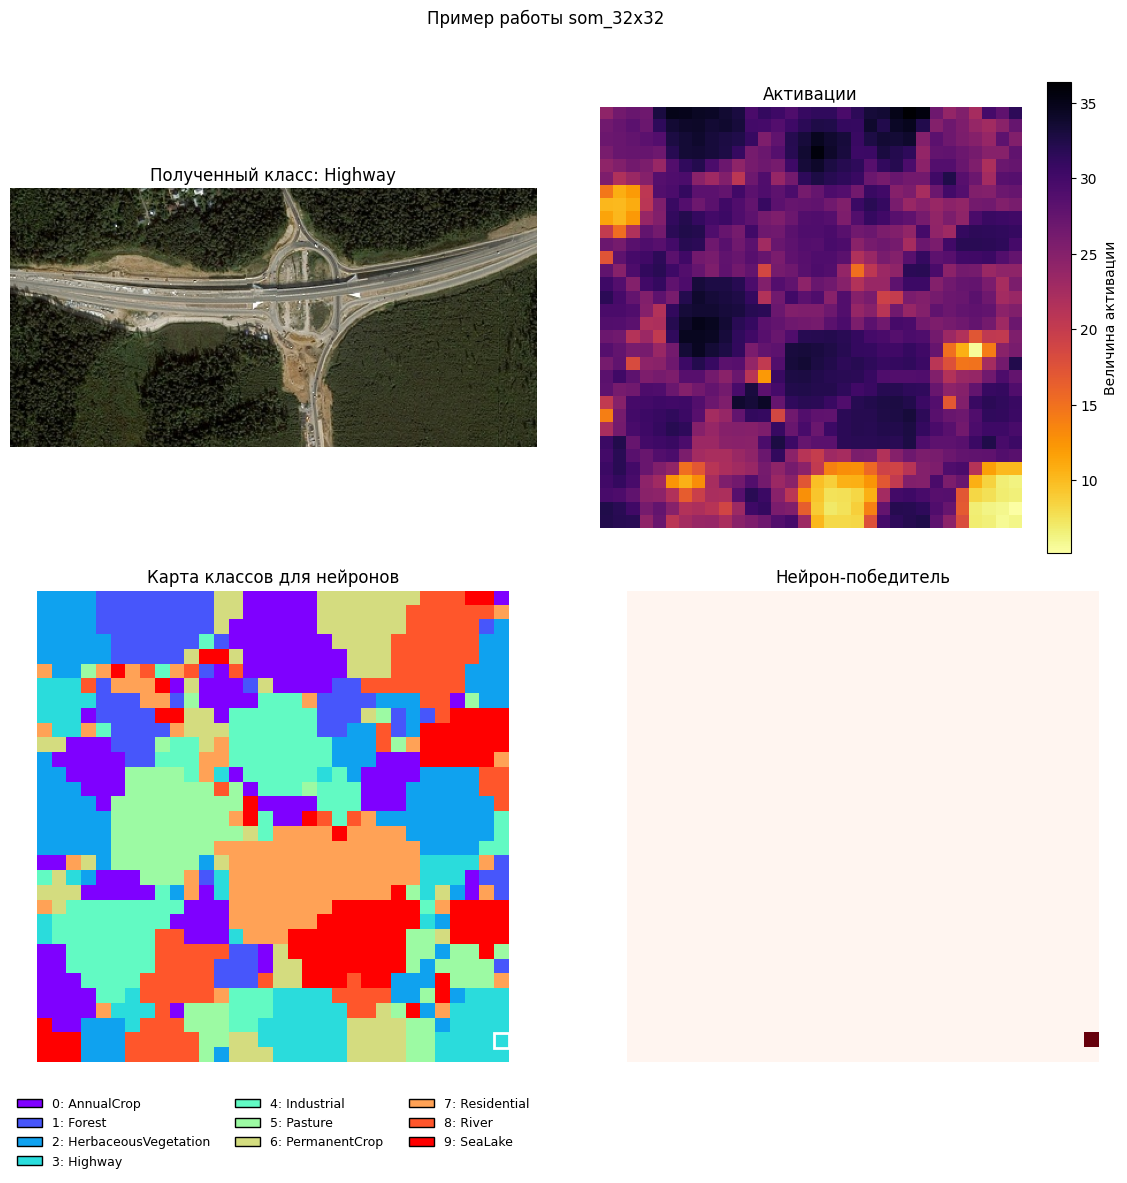

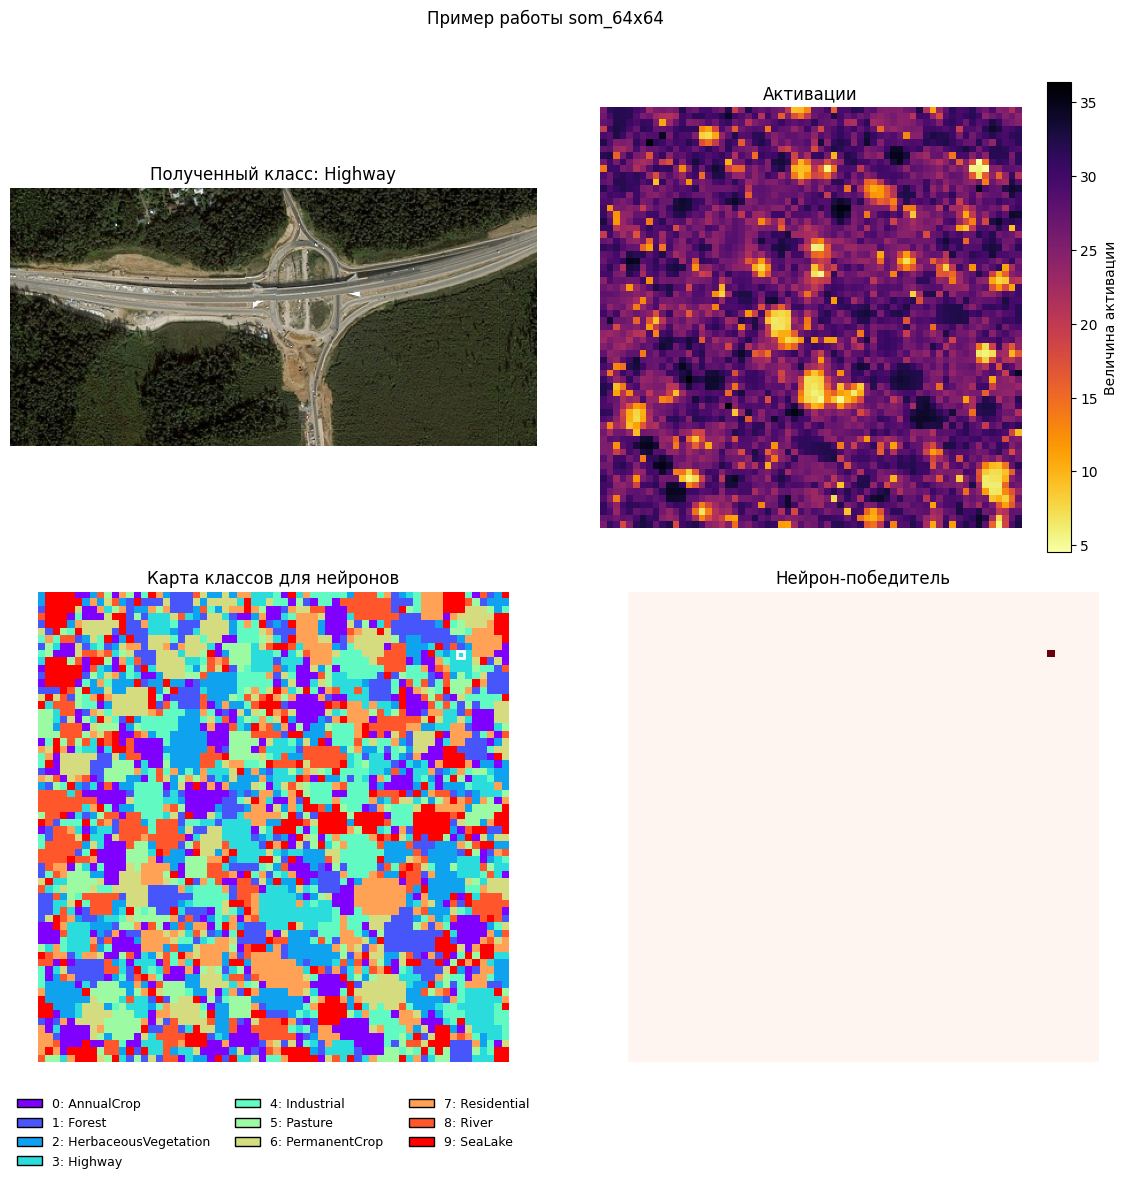

In [54]:
filepath = "../test_examples/ya_map_6.png"
img = Image.open(filepath).convert("RGB")

transform = train_ds.transform
with torch.no_grad():
    x = transform(img).unsqueeze(0).to(device)
    logits, emb = model(x)

cls_pred = int(torch.softmax(logits.cpu(), 1).argmax())

for cfg_name, som in som_trained.items():
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    ax[0,0].imshow(img)
    ax[0,0].set_title(f"Полученный класс: {inv_labels_dict[cls_pred]}")
    ax[0,0].axis("off")
    
    act_img = ax[0,1].imshow(som.activate(emb.cpu()).T, cmap=plt.cm.inferno_r, origin="upper")
    ax[0,1].axis("off")
    ax[0,1].set_title(f"Активации")
    
    fig.colorbar(act_img, ax=ax[0,1], label="Величина активации")
    
    ax[1,1].imshow(som.activation_response(emb.cpu()).T, cmap="Reds", origin="upper")
    ax[1,1].axis("off")
    ax[1,1].set_title("Нейрон-победитель")
    
    #здесь строим классификацию элементов карти Кохенена
    weights = som.get_weights()
    weights_shape = weights.shape
    weights = torch.tensor(weights, dtype=torch.float32).reshape(-1, weights.shape[-1]).to(device)
    weights_logits = model.classifier(weights)
    cls = torch.softmax(weights_logits, axis=1).argmax(axis=1).cpu()
    cls = cls.reshape(weights_shape[:2])
    
    ax[1,0].imshow(cls.T, cmap="rainbow", origin="upper")
    ax[1,0].axis("off")
    x, y = som.winner(emb.cpu().squeeze())
    rect = Rectangle((x-0.5,y-0.5), 1, 1, edgecolor="white", linewidth=2, facecolor="none")
    ax[1,0].add_patch(rect)
    ax[1,0].set_title(f"Карта классов для нейронов")
    
    legend_elements = []
    cmap_cls = plt.cm.rainbow
    norm_cls = mcolors.Normalize(vmin=0, vmax=9)
    for cls_id in sorted(inv_labels_dict.keys()):
        cls_name = inv_labels_dict[cls_id]
        color = cmap_cls(norm_cls(cls_id))
        legend_elements.append(Patch(facecolor=color, edgecolor='black', label=f"{cls_id}: {cls_name}"))
    
    # Располагаем легенду под графиком
    ax[1,0].legend(handles=legend_elements, 
                     loc='upper center', 
                     bbox_to_anchor=(0.5, -0.05), # Сдвиг вниз
                     ncol=3,                      # Количество колонок
                     fontsize=9,
                     frameon=False)
    
    fig.suptitle(f"Пример работы som_{som.get_weights().shape[0]}x{som.get_weights().shape[1]}")
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(f"../resulting_images/example_som_{som.get_weights().shape[0]}x{som.get_weights().shape[1]}.png")
    plt.show()